In [1]:
PREFIX = './fragments/Frag1/'

In [2]:
import glob

import tqdm
import numpy
import PIL.Image

image = numpy.stack([ numpy.array(PIL.Image.open(file)) for file in tqdm.tqdm(glob.glob(f"{PREFIX}/surface_volume/*.tif")[1::2]) ]) / 65535
print(image.min(), image.max(), image.shape)

mask = numpy.array(PIL.Image.open(f"{PREFIX}/mask.png"))
print(mask.min(), mask.max(), mask.shape)

target = numpy.array(PIL.Image.open(f"{PREFIX}/inklabels.png"))
print(target.min(), target.max(), target.shape)

100%|██████████| 32/32 [00:06<00:00,  5.10it/s]


0.0 1.0 (32, 8181, 6330)
0 1 (8181, 6330)
0 1 (8181, 6330)


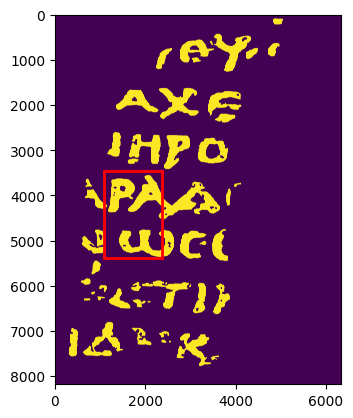

In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

VAL_X = (1088, 2368)
VAL_Y = (3456, 5376)

plt.imshow(target)
plt.gca().add_patch(
    patches.Rectangle(
        (VAL_X[0], VAL_Y[0]),
        VAL_X[1] - VAL_X[0],
        VAL_Y[1] - VAL_Y[0],
        linewidth = 2,
        edgecolor = 'r',
        facecolor = 'none'
    )
)

In [4]:
WINDOW = 128
HALF = (WINDOW // 2)
PADDING = (WINDOW // 4)

train_images, train_labels, train_idxs = [], [], []
test_images, test_labels, test_idxs = [], [], []
for i in range(image.shape[1] - WINDOW):
    if i % HALF != 0:
        continue
    for j in range(image.shape[2] - WINDOW):
        if j % HALF != 0:
            continue
        if mask[i][j] == 0:
            continue

        img = image[:, i:i + WINDOW, j:j + WINDOW]
        label = target[i:i + WINDOW, j:j + WINDOW]

        if (i > VAL_Y[0]) and (i < VAL_Y[1]) and (j > VAL_X[0]) and (j < VAL_X[1]):
            test_images.append(img)
            test_labels.append(label)
            test_idxs.append((i, j))
        else:
            train_images.append(img)
            train_labels.append(label)
            train_idxs.append((i, j))

train_images = numpy.stack(train_images)
train_labels = numpy.stack(train_labels)
test_images = numpy.stack(test_images)
test_labels = numpy.stack(test_labels)

print(train_images.shape, train_labels.shape, test_images.shape, test_labels.shape)

(6521, 32, 128, 128) (6521, 128, 128) (551, 32, 128, 128) (551, 128, 128)


In [5]:
import gc

del image
gc.collect()

20

In [6]:
import torchvision.tv_tensors
import torchvision.transforms.v2

RESIZE_FACTOR = 2

WINDOW = WINDOW // RESIZE_FACTOR
HALF = (WINDOW // 2)
PADDING = (WINDOW // 4)

transform = torchvision.transforms.v2.Resize((WINDOW, WINDOW))

def resize(images, labels, idxs):
    images = torchvision.tv_tensors.Image(images)
    labels = torchvision.tv_tensors.Mask(labels)
    images, labels = transform(images, labels)
    idxs = [(i // RESIZE_FACTOR, j // RESIZE_FACTOR) for (i, j) in idxs]
    return images.numpy(), labels.numpy(), idxs

train_images, train_labels, train_idxs = resize(train_images, train_labels, train_idxs)
test_images, test_labels, test_idxs = resize(test_images, test_labels, test_idxs)

print(train_images.shape, train_labels.shape, test_images.shape, test_labels.shape)

(6521, 32, 64, 64) (6521, 64, 64) (551, 32, 64, 64) (551, 64, 64)


In [7]:
import cvtda.topology

extractor = cvtda.topology.FeatureExtractor(n_jobs = 14, only_get_from_dump = False, return_diagrams = False)
extractor = extractor.fit(train_images, f"{PREFIX}/3d/train")
train_features = extractor.transform(train_images, f"{PREFIX}/3d/train")
test_features = extractor.transform(test_images, f"{PREFIX}/3d/test")

train_features.shape, test_features.shape

Calculating inverted images
GreyscaleExtractor: processing ./fragments/Frag1//3d/train/greyscale, do_fit = True
Got the result from ././fragments/Frag1//3d/train/greyscale/diagrams.npy
Applying Scaler to persistence diagrams.
DiagramVectorizer: fitting complete
Got the result from ././fragments/Frag1//3d/train/greyscale/features.npy
GreyscaleExtractor: processing ./fragments/Frag1//3d/train/greyscale, do_fit = False
Got the result from ././fragments/Frag1//3d/train/greyscale/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/train/greyscale/features.npy
GreyscaleExtractor: processing ./fragments/Frag1//3d/train/inverted_greyscale, do_fit = True
Got the result from ././fragments/Frag1//3d/train/inverted_greyscale/diagrams.npy
Applying Scaler to persistence diagrams.
DiagramVectorizer: fitting complete
Got the result from ././fragments/Frag1//3d/train/inverted_greyscale/features.npy
GreyscaleExtractor: processing ./fragments/Frag1//3d/train/

DiagramVectorizer: batch: 100%|██████████| 13/13 [00:05<00:00,  2.30it/s]


Saving the result to ././fragments/Frag1//3d/train/filtrations/6/HeightFiltrartion_-1_1/features.npy
Fitting filtration 188/270: 6/HeightFiltrartion_-1_1
FiltrationExtractor: processing ./fragments/Frag1//3d/train/filtrations/6/HeightFiltrartion_-1_1, do_fit = True, filtration = HeightFiltration(direction=array([-1,  1,  0]), n_jobs=14)


d:\Programs\Programming\Python\lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Got the result from ././fragments/Frag1//3d/train/filtrations/6/HeightFiltrartion_-1_1/diagrams.npy
Applying Scaler to persistence diagrams.
DiagramVectorizer: fitting complete
Got the result from ././fragments/Frag1//3d/train/filtrations/6/HeightFiltrartion_-1_1/features.npy
Fitting filtration 189/270: 6/HeightFiltrartion_-1_1
FiltrationExtractor: processing ./fragments/Frag1//3d/train/filtrations/6/HeightFiltrartion_-1_1, do_fit = True, filtration = HeightFiltration(direction=array([-1,  1,  1]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/train/filtrations/6/HeightFiltrartion_-1_1/diagrams.npy
Applying Scaler to persistence diagrams.
DiagramVectorizer: fitting complete
Got the result from ././fragments/Frag1//3d/train/filtrations/6/HeightFiltrartion_-1_1/features.npy
Fitting filtration 190/270: 6/HeightFiltrartion_0_-1
FiltrationExtractor: processing ./fragments/Frag1//3d/train/filtrations/6/HeightFiltrartion_0_-1, do_fit = True, filtration = HeightFiltration(direction=ar

DiagramVectorizer: batch: 100%|██████████| 13/13 [00:05<00:00,  2.42it/s]


Saving the result to ././fragments/Frag1//3d/train/filtrations/6/HeightFiltrartion_0_-1/features.npy
Fitting filtration 191/270: 6/HeightFiltrartion_0_-1
FiltrationExtractor: processing ./fragments/Frag1//3d/train/filtrations/6/HeightFiltrartion_0_-1, do_fit = True, filtration = HeightFiltration(direction=array([ 0, -1,  0]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/train/filtrations/6/HeightFiltrartion_0_-1/diagrams.npy
Applying Scaler to persistence diagrams.
DiagramVectorizer: fitting complete
Got the result from ././fragments/Frag1//3d/train/filtrations/6/HeightFiltrartion_0_-1/features.npy
Fitting filtration 192/270: 6/HeightFiltrartion_0_-1
FiltrationExtractor: processing ./fragments/Frag1//3d/train/filtrations/6/HeightFiltrartion_0_-1, do_fit = True, filtration = HeightFiltration(direction=array([ 0, -1,  1]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/train/filtrations/6/HeightFiltrartion_0_-1/diagrams.npy
Applying Scaler to persistence diagrams.
Diagr

DiagramVectorizer: batch: 100%|██████████| 13/13 [00:05<00:00,  2.57it/s]


Saving the result to ././fragments/Frag1//3d/train/filtrations/6/HeightFiltrartion_0_0/features.npy
Fitting filtration 194/270: 6/HeightFiltrartion_0_0
FiltrationExtractor: processing ./fragments/Frag1//3d/train/filtrations/6/HeightFiltrartion_0_0, do_fit = True, filtration = HeightFiltration(direction=array([0, 0, 1]), n_jobs=14)


d:\Programs\Programming\Python\lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Got the result from ././fragments/Frag1//3d/train/filtrations/6/HeightFiltrartion_0_0/diagrams.npy
Applying Scaler to persistence diagrams.
DiagramVectorizer: fitting complete
Got the result from ././fragments/Frag1//3d/train/filtrations/6/HeightFiltrartion_0_0/features.npy
Fitting filtration 195/270: 6/HeightFiltrartion_0_1
FiltrationExtractor: processing ./fragments/Frag1//3d/train/filtrations/6/HeightFiltrartion_0_1, do_fit = True, filtration = HeightFiltration(direction=array([ 0,  1, -1]), n_jobs=14)
Saving the result to ././fragments/Frag1//3d/train/filtrations/6/HeightFiltrartion_0_1/diagrams.npy
Applying Scaler to persistence diagrams.
DiagramVectorizer: fitting complete


DiagramVectorizer: batch: 100%|██████████| 13/13 [00:06<00:00,  2.07it/s]


Saving the result to ././fragments/Frag1//3d/train/filtrations/6/HeightFiltrartion_0_1/features.npy
Fitting filtration 196/270: 6/HeightFiltrartion_0_1
FiltrationExtractor: processing ./fragments/Frag1//3d/train/filtrations/6/HeightFiltrartion_0_1, do_fit = True, filtration = HeightFiltration(direction=array([0, 1, 0]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/train/filtrations/6/HeightFiltrartion_0_1/diagrams.npy
Applying Scaler to persistence diagrams.
DiagramVectorizer: fitting complete
Got the result from ././fragments/Frag1//3d/train/filtrations/6/HeightFiltrartion_0_1/features.npy
Fitting filtration 197/270: 6/HeightFiltrartion_0_1
FiltrationExtractor: processing ./fragments/Frag1//3d/train/filtrations/6/HeightFiltrartion_0_1, do_fit = True, filtration = HeightFiltration(direction=array([0, 1, 1]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/train/filtrations/6/HeightFiltrartion_0_1/diagrams.npy
Applying Scaler to persistence diagrams.
DiagramVectorizer: 

DiagramVectorizer: batch: 100%|██████████| 13/13 [00:05<00:00,  2.40it/s]


Saving the result to ././fragments/Frag1//3d/train/filtrations/6/HeightFiltrartion_1_-1/features.npy
Fitting filtration 199/270: 6/HeightFiltrartion_1_-1
FiltrationExtractor: processing ./fragments/Frag1//3d/train/filtrations/6/HeightFiltrartion_1_-1, do_fit = True, filtration = HeightFiltration(direction=array([ 1, -1,  0]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/train/filtrations/6/HeightFiltrartion_1_-1/diagrams.npy
Applying Scaler to persistence diagrams.
DiagramVectorizer: fitting complete
Got the result from ././fragments/Frag1//3d/train/filtrations/6/HeightFiltrartion_1_-1/features.npy
Fitting filtration 200/270: 6/HeightFiltrartion_1_-1
FiltrationExtractor: processing ./fragments/Frag1//3d/train/filtrations/6/HeightFiltrartion_1_-1, do_fit = True, filtration = HeightFiltration(direction=array([ 1, -1,  1]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/train/filtrations/6/HeightFiltrartion_1_-1/diagrams.npy
Applying Scaler to persistence diagrams.
Diagr

DiagramVectorizer: batch: 100%|██████████| 13/13 [00:06<00:00,  2.16it/s]


Saving the result to ././fragments/Frag1//3d/train/filtrations/6/HeightFiltrartion_1_0/features.npy
Fitting filtration 202/270: 6/HeightFiltrartion_1_0
FiltrationExtractor: processing ./fragments/Frag1//3d/train/filtrations/6/HeightFiltrartion_1_0, do_fit = True, filtration = HeightFiltration(direction=array([1, 0, 0]), n_jobs=14)


d:\Programs\Programming\Python\lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Got the result from ././fragments/Frag1//3d/train/filtrations/6/HeightFiltrartion_1_0/diagrams.npy
Applying Scaler to persistence diagrams.
DiagramVectorizer: fitting complete
Got the result from ././fragments/Frag1//3d/train/filtrations/6/HeightFiltrartion_1_0/features.npy
Fitting filtration 203/270: 6/HeightFiltrartion_1_0
FiltrationExtractor: processing ./fragments/Frag1//3d/train/filtrations/6/HeightFiltrartion_1_0, do_fit = True, filtration = HeightFiltration(direction=array([1, 0, 1]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/train/filtrations/6/HeightFiltrartion_1_0/diagrams.npy
Applying Scaler to persistence diagrams.
DiagramVectorizer: fitting complete
Got the result from ././fragments/Frag1//3d/train/filtrations/6/HeightFiltrartion_1_0/features.npy
Fitting filtration 204/270: 6/HeightFiltrartion_1_1
FiltrationExtractor: processing ./fragments/Frag1//3d/train/filtrations/6/HeightFiltrartion_1_1, do_fit = True, filtration = HeightFiltration(direction=array([ 1,  1

DiagramVectorizer: batch: 100%|██████████| 13/13 [00:05<00:00,  2.26it/s]


Saving the result to ././fragments/Frag1//3d/train/filtrations/6/HeightFiltrartion_1_1/features.npy
Fitting filtration 205/270: 6/HeightFiltrartion_1_1
FiltrationExtractor: processing ./fragments/Frag1//3d/train/filtrations/6/HeightFiltrartion_1_1, do_fit = True, filtration = HeightFiltration(direction=array([1, 1, 0]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/train/filtrations/6/HeightFiltrartion_1_1/diagrams.npy
Applying Scaler to persistence diagrams.
DiagramVectorizer: fitting complete
Got the result from ././fragments/Frag1//3d/train/filtrations/6/HeightFiltrartion_1_1/features.npy
Fitting filtration 206/270: 6/HeightFiltrartion_1_1
FiltrationExtractor: processing ./fragments/Frag1//3d/train/filtrations/6/HeightFiltrartion_1_1, do_fit = True, filtration = HeightFiltration(direction=array([1, 1, 1]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/train/filtrations/6/HeightFiltrartion_1_1/diagrams.npy
Applying Scaler to persistence diagrams.
DiagramVectorizer: 

DiagramVectorizer: batch: 100%|██████████| 13/13 [00:05<00:00,  2.40it/s]


Saving the result to ././fragments/Frag1//3d/train/filtrations/6/RadialFiltration_5_12/features.npy
Fitting filtration 208/270: 6/RadialFiltration_5_12
FiltrationExtractor: processing ./fragments/Frag1//3d/train/filtrations/6/RadialFiltration_5_12, do_fit = True, filtration = RadialFiltration(center=array([ 5, 12, 25]), n_jobs=14)


d:\Programs\Programming\Python\lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Got the result from ././fragments/Frag1//3d/train/filtrations/6/RadialFiltration_5_12/diagrams.npy
Applying Scaler to persistence diagrams.
DiagramVectorizer: fitting complete
Got the result from ././fragments/Frag1//3d/train/filtrations/6/RadialFiltration_5_12/features.npy
Fitting filtration 209/270: 6/RadialFiltration_5_12
FiltrationExtractor: processing ./fragments/Frag1//3d/train/filtrations/6/RadialFiltration_5_12, do_fit = True, filtration = RadialFiltration(center=array([ 5, 12, 38]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/train/filtrations/6/RadialFiltration_5_12/diagrams.npy
Applying Scaler to persistence diagrams.
DiagramVectorizer: fitting complete
Got the result from ././fragments/Frag1//3d/train/filtrations/6/RadialFiltration_5_12/features.npy
Fitting filtration 210/270: 6/RadialFiltration_5_12
FiltrationExtractor: processing ./fragments/Frag1//3d/train/filtrations/6/RadialFiltration_5_12, do_fit = True, filtration = RadialFiltration(center=array([ 5, 12, 5

DiagramVectorizer: batch: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s]


Saving the result to ././fragments/Frag1//3d/train/filtrations/6/RadialFiltration_5_25/features.npy
Fitting filtration 212/270: 6/RadialFiltration_5_25
FiltrationExtractor: processing ./fragments/Frag1//3d/train/filtrations/6/RadialFiltration_5_25, do_fit = True, filtration = RadialFiltration(center=array([ 5, 25, 25]), n_jobs=14)


d:\Programs\Programming\Python\lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Got the result from ././fragments/Frag1//3d/train/filtrations/6/RadialFiltration_5_25/diagrams.npy
Applying Scaler to persistence diagrams.
DiagramVectorizer: fitting complete
Got the result from ././fragments/Frag1//3d/train/filtrations/6/RadialFiltration_5_25/features.npy
Fitting filtration 213/270: 6/RadialFiltration_5_25
FiltrationExtractor: processing ./fragments/Frag1//3d/train/filtrations/6/RadialFiltration_5_25, do_fit = True, filtration = RadialFiltration(center=array([ 5, 25, 38]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/train/filtrations/6/RadialFiltration_5_25/diagrams.npy
Applying Scaler to persistence diagrams.
DiagramVectorizer: fitting complete
Got the result from ././fragments/Frag1//3d/train/filtrations/6/RadialFiltration_5_25/features.npy
Fitting filtration 214/270: 6/RadialFiltration_5_25
FiltrationExtractor: processing ./fragments/Frag1//3d/train/filtrations/6/RadialFiltration_5_25, do_fit = True, filtration = RadialFiltration(center=array([ 5, 25, 5

DiagramVectorizer: batch: 100%|██████████| 13/13 [00:05<00:00,  2.48it/s]


Saving the result to ././fragments/Frag1//3d/train/filtrations/6/RadialFiltration_5_38/features.npy
Fitting filtration 216/270: 6/RadialFiltration_5_38
FiltrationExtractor: processing ./fragments/Frag1//3d/train/filtrations/6/RadialFiltration_5_38, do_fit = True, filtration = RadialFiltration(center=array([ 5, 38, 25]), n_jobs=14)


d:\Programs\Programming\Python\lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Got the result from ././fragments/Frag1//3d/train/filtrations/6/RadialFiltration_5_38/diagrams.npy
Applying Scaler to persistence diagrams.
DiagramVectorizer: fitting complete
Got the result from ././fragments/Frag1//3d/train/filtrations/6/RadialFiltration_5_38/features.npy
Fitting filtration 217/270: 6/RadialFiltration_5_38
FiltrationExtractor: processing ./fragments/Frag1//3d/train/filtrations/6/RadialFiltration_5_38, do_fit = True, filtration = RadialFiltration(center=array([ 5, 38, 38]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/train/filtrations/6/RadialFiltration_5_38/diagrams.npy
Applying Scaler to persistence diagrams.
DiagramVectorizer: fitting complete
Got the result from ././fragments/Frag1//3d/train/filtrations/6/RadialFiltration_5_38/features.npy
Fitting filtration 218/270: 6/RadialFiltration_5_38
FiltrationExtractor: processing ./fragments/Frag1//3d/train/filtrations/6/RadialFiltration_5_38, do_fit = True, filtration = RadialFiltration(center=array([ 5, 38, 5

DiagramVectorizer: batch: 100%|██████████| 13/13 [00:05<00:00,  2.57it/s]


Saving the result to ././fragments/Frag1//3d/train/filtrations/6/RadialFiltration_5_51/features.npy
Fitting filtration 220/270: 6/RadialFiltration_5_51
FiltrationExtractor: processing ./fragments/Frag1//3d/train/filtrations/6/RadialFiltration_5_51, do_fit = True, filtration = RadialFiltration(center=array([ 5, 51, 25]), n_jobs=14)


d:\Programs\Programming\Python\lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Got the result from ././fragments/Frag1//3d/train/filtrations/6/RadialFiltration_5_51/diagrams.npy
Applying Scaler to persistence diagrams.
DiagramVectorizer: fitting complete
Got the result from ././fragments/Frag1//3d/train/filtrations/6/RadialFiltration_5_51/features.npy
Fitting filtration 221/270: 6/RadialFiltration_5_51
FiltrationExtractor: processing ./fragments/Frag1//3d/train/filtrations/6/RadialFiltration_5_51, do_fit = True, filtration = RadialFiltration(center=array([ 5, 51, 38]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/train/filtrations/6/RadialFiltration_5_51/diagrams.npy
Applying Scaler to persistence diagrams.
DiagramVectorizer: fitting complete
Got the result from ././fragments/Frag1//3d/train/filtrations/6/RadialFiltration_5_51/features.npy
Fitting filtration 222/270: 6/RadialFiltration_5_51
FiltrationExtractor: processing ./fragments/Frag1//3d/train/filtrations/6/RadialFiltration_5_51, do_fit = True, filtration = RadialFiltration(center=array([ 5, 51, 5

DiagramVectorizer: batch: 100%|██████████| 13/13 [00:06<00:00,  1.91it/s]


Saving the result to ././fragments/Frag1//3d/train/filtrations/6/RadialFiltration_12_12/features.npy
Fitting filtration 224/270: 6/RadialFiltration_12_12
FiltrationExtractor: processing ./fragments/Frag1//3d/train/filtrations/6/RadialFiltration_12_12, do_fit = True, filtration = RadialFiltration(center=array([12, 12, 25]), n_jobs=14)


d:\Programs\Programming\Python\lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Got the result from ././fragments/Frag1//3d/train/filtrations/6/RadialFiltration_12_12/diagrams.npy
Applying Scaler to persistence diagrams.
DiagramVectorizer: fitting complete
Got the result from ././fragments/Frag1//3d/train/filtrations/6/RadialFiltration_12_12/features.npy
Fitting filtration 225/270: 6/RadialFiltration_12_12
FiltrationExtractor: processing ./fragments/Frag1//3d/train/filtrations/6/RadialFiltration_12_12, do_fit = True, filtration = RadialFiltration(center=array([12, 12, 38]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/train/filtrations/6/RadialFiltration_12_12/diagrams.npy
Applying Scaler to persistence diagrams.
DiagramVectorizer: fitting complete
Got the result from ././fragments/Frag1//3d/train/filtrations/6/RadialFiltration_12_12/features.npy
Fitting filtration 226/270: 6/RadialFiltration_12_12
FiltrationExtractor: processing ./fragments/Frag1//3d/train/filtrations/6/RadialFiltration_12_12, do_fit = True, filtration = RadialFiltration(center=array([1

DiagramVectorizer: batch: 100%|██████████| 13/13 [00:04<00:00,  2.86it/s]


Saving the result to ././fragments/Frag1//3d/train/filtrations/6/RadialFiltration_12_25/features.npy
Fitting filtration 228/270: 6/RadialFiltration_12_25
FiltrationExtractor: processing ./fragments/Frag1//3d/train/filtrations/6/RadialFiltration_12_25, do_fit = True, filtration = RadialFiltration(center=array([12, 25, 25]), n_jobs=14)


d:\Programs\Programming\Python\lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Got the result from ././fragments/Frag1//3d/train/filtrations/6/RadialFiltration_12_25/diagrams.npy
Applying Scaler to persistence diagrams.
DiagramVectorizer: fitting complete
Got the result from ././fragments/Frag1//3d/train/filtrations/6/RadialFiltration_12_25/features.npy
Fitting filtration 229/270: 6/RadialFiltration_12_25
FiltrationExtractor: processing ./fragments/Frag1//3d/train/filtrations/6/RadialFiltration_12_25, do_fit = True, filtration = RadialFiltration(center=array([12, 25, 38]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/train/filtrations/6/RadialFiltration_12_25/diagrams.npy
Applying Scaler to persistence diagrams.
DiagramVectorizer: fitting complete
Got the result from ././fragments/Frag1//3d/train/filtrations/6/RadialFiltration_12_25/features.npy
Fitting filtration 230/270: 6/RadialFiltration_12_25
FiltrationExtractor: processing ./fragments/Frag1//3d/train/filtrations/6/RadialFiltration_12_25, do_fit = True, filtration = RadialFiltration(center=array([1

DiagramVectorizer: batch: 100%|██████████| 13/13 [00:04<00:00,  2.79it/s]


Saving the result to ././fragments/Frag1//3d/train/filtrations/6/RadialFiltration_12_38/features.npy
Fitting filtration 232/270: 6/RadialFiltration_12_38
FiltrationExtractor: processing ./fragments/Frag1//3d/train/filtrations/6/RadialFiltration_12_38, do_fit = True, filtration = RadialFiltration(center=array([12, 38, 25]), n_jobs=14)


d:\Programs\Programming\Python\lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Got the result from ././fragments/Frag1//3d/train/filtrations/6/RadialFiltration_12_38/diagrams.npy
Applying Scaler to persistence diagrams.
DiagramVectorizer: fitting complete
Got the result from ././fragments/Frag1//3d/train/filtrations/6/RadialFiltration_12_38/features.npy
Fitting filtration 233/270: 6/RadialFiltration_12_38
FiltrationExtractor: processing ./fragments/Frag1//3d/train/filtrations/6/RadialFiltration_12_38, do_fit = True, filtration = RadialFiltration(center=array([12, 38, 38]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/train/filtrations/6/RadialFiltration_12_38/diagrams.npy
Applying Scaler to persistence diagrams.
DiagramVectorizer: fitting complete
Got the result from ././fragments/Frag1//3d/train/filtrations/6/RadialFiltration_12_38/features.npy
Fitting filtration 234/270: 6/RadialFiltration_12_38
FiltrationExtractor: processing ./fragments/Frag1//3d/train/filtrations/6/RadialFiltration_12_38, do_fit = True, filtration = RadialFiltration(center=array([1

DiagramVectorizer: batch: 100%|██████████| 13/13 [00:05<00:00,  2.57it/s]


Saving the result to ././fragments/Frag1//3d/train/filtrations/6/RadialFiltration_12_51/features.npy
Fitting filtration 236/270: 6/RadialFiltration_12_51
FiltrationExtractor: processing ./fragments/Frag1//3d/train/filtrations/6/RadialFiltration_12_51, do_fit = True, filtration = RadialFiltration(center=array([12, 51, 25]), n_jobs=14)


d:\Programs\Programming\Python\lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Got the result from ././fragments/Frag1//3d/train/filtrations/6/RadialFiltration_12_51/diagrams.npy
Applying Scaler to persistence diagrams.
DiagramVectorizer: fitting complete
Got the result from ././fragments/Frag1//3d/train/filtrations/6/RadialFiltration_12_51/features.npy
Fitting filtration 237/270: 6/RadialFiltration_12_51
FiltrationExtractor: processing ./fragments/Frag1//3d/train/filtrations/6/RadialFiltration_12_51, do_fit = True, filtration = RadialFiltration(center=array([12, 51, 38]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/train/filtrations/6/RadialFiltration_12_51/diagrams.npy
Applying Scaler to persistence diagrams.
DiagramVectorizer: fitting complete
Got the result from ././fragments/Frag1//3d/train/filtrations/6/RadialFiltration_12_51/features.npy
Fitting filtration 238/270: 6/RadialFiltration_12_51
FiltrationExtractor: processing ./fragments/Frag1//3d/train/filtrations/6/RadialFiltration_12_51, do_fit = True, filtration = RadialFiltration(center=array([1

DiagramVectorizer: batch: 100%|██████████| 13/13 [00:05<00:00,  2.18it/s]


Saving the result to ././fragments/Frag1//3d/train/filtrations/6/RadialFiltration_19_12/features.npy
Fitting filtration 240/270: 6/RadialFiltration_19_12
FiltrationExtractor: processing ./fragments/Frag1//3d/train/filtrations/6/RadialFiltration_19_12, do_fit = True, filtration = RadialFiltration(center=array([19, 12, 25]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/train/filtrations/6/RadialFiltration_19_12/diagrams.npy
Applying Scaler to persistence diagrams.
DiagramVectorizer: fitting complete
Got the result from ././fragments/Frag1//3d/train/filtrations/6/RadialFiltration_19_12/features.npy
Fitting filtration 241/270: 6/RadialFiltration_19_12
FiltrationExtractor: processing ./fragments/Frag1//3d/train/filtrations/6/RadialFiltration_19_12, do_fit = True, filtration = RadialFiltration(center=array([19, 12, 38]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/train/filtrations/6/RadialFiltration_19_12/diagrams.npy
Applying Scaler to persistence diagrams.
DiagramVect

DiagramVectorizer: batch: 100%|██████████| 13/13 [00:05<00:00,  2.42it/s]


Saving the result to ././fragments/Frag1//3d/train/filtrations/6/RadialFiltration_19_25/features.npy
Fitting filtration 244/270: 6/RadialFiltration_19_25
FiltrationExtractor: processing ./fragments/Frag1//3d/train/filtrations/6/RadialFiltration_19_25, do_fit = True, filtration = RadialFiltration(center=array([19, 25, 25]), n_jobs=14)


d:\Programs\Programming\Python\lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Got the result from ././fragments/Frag1//3d/train/filtrations/6/RadialFiltration_19_25/diagrams.npy
Applying Scaler to persistence diagrams.
DiagramVectorizer: fitting complete
Got the result from ././fragments/Frag1//3d/train/filtrations/6/RadialFiltration_19_25/features.npy
Fitting filtration 245/270: 6/RadialFiltration_19_25
FiltrationExtractor: processing ./fragments/Frag1//3d/train/filtrations/6/RadialFiltration_19_25, do_fit = True, filtration = RadialFiltration(center=array([19, 25, 38]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/train/filtrations/6/RadialFiltration_19_25/diagrams.npy
Applying Scaler to persistence diagrams.
DiagramVectorizer: fitting complete
Got the result from ././fragments/Frag1//3d/train/filtrations/6/RadialFiltration_19_25/features.npy
Fitting filtration 246/270: 6/RadialFiltration_19_25
FiltrationExtractor: processing ./fragments/Frag1//3d/train/filtrations/6/RadialFiltration_19_25, do_fit = True, filtration = RadialFiltration(center=array([1

DiagramVectorizer: batch: 100%|██████████| 13/13 [00:05<00:00,  2.55it/s]


Saving the result to ././fragments/Frag1//3d/train/filtrations/6/RadialFiltration_19_38/features.npy
Fitting filtration 248/270: 6/RadialFiltration_19_38
FiltrationExtractor: processing ./fragments/Frag1//3d/train/filtrations/6/RadialFiltration_19_38, do_fit = True, filtration = RadialFiltration(center=array([19, 38, 25]), n_jobs=14)


d:\Programs\Programming\Python\lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Got the result from ././fragments/Frag1//3d/train/filtrations/6/RadialFiltration_19_38/diagrams.npy
Applying Scaler to persistence diagrams.
DiagramVectorizer: fitting complete
Got the result from ././fragments/Frag1//3d/train/filtrations/6/RadialFiltration_19_38/features.npy
Fitting filtration 249/270: 6/RadialFiltration_19_38
FiltrationExtractor: processing ./fragments/Frag1//3d/train/filtrations/6/RadialFiltration_19_38, do_fit = True, filtration = RadialFiltration(center=array([19, 38, 38]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/train/filtrations/6/RadialFiltration_19_38/diagrams.npy
Applying Scaler to persistence diagrams.
DiagramVectorizer: fitting complete
Got the result from ././fragments/Frag1//3d/train/filtrations/6/RadialFiltration_19_38/features.npy
Fitting filtration 250/270: 6/RadialFiltration_19_38
FiltrationExtractor: processing ./fragments/Frag1//3d/train/filtrations/6/RadialFiltration_19_38, do_fit = True, filtration = RadialFiltration(center=array([1

DiagramVectorizer: batch: 100%|██████████| 13/13 [00:04<00:00,  2.64it/s]


Saving the result to ././fragments/Frag1//3d/train/filtrations/6/RadialFiltration_19_51/features.npy
Fitting filtration 252/270: 6/RadialFiltration_19_51
FiltrationExtractor: processing ./fragments/Frag1//3d/train/filtrations/6/RadialFiltration_19_51, do_fit = True, filtration = RadialFiltration(center=array([19, 51, 25]), n_jobs=14)


d:\Programs\Programming\Python\lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Got the result from ././fragments/Frag1//3d/train/filtrations/6/RadialFiltration_19_51/diagrams.npy
Applying Scaler to persistence diagrams.
DiagramVectorizer: fitting complete
Got the result from ././fragments/Frag1//3d/train/filtrations/6/RadialFiltration_19_51/features.npy
Fitting filtration 253/270: 6/RadialFiltration_19_51
FiltrationExtractor: processing ./fragments/Frag1//3d/train/filtrations/6/RadialFiltration_19_51, do_fit = True, filtration = RadialFiltration(center=array([19, 51, 38]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/train/filtrations/6/RadialFiltration_19_51/diagrams.npy
Applying Scaler to persistence diagrams.
DiagramVectorizer: fitting complete
Got the result from ././fragments/Frag1//3d/train/filtrations/6/RadialFiltration_19_51/features.npy
Fitting filtration 254/270: 6/RadialFiltration_19_51
FiltrationExtractor: processing ./fragments/Frag1//3d/train/filtrations/6/RadialFiltration_19_51, do_fit = True, filtration = RadialFiltration(center=array([1

DiagramVectorizer: batch: 100%|██████████| 13/13 [00:06<00:00,  1.87it/s]


Saving the result to ././fragments/Frag1//3d/train/filtrations/6/RadialFiltration_26_12/features.npy
Fitting filtration 256/270: 6/RadialFiltration_26_12
FiltrationExtractor: processing ./fragments/Frag1//3d/train/filtrations/6/RadialFiltration_26_12, do_fit = True, filtration = RadialFiltration(center=array([26, 12, 25]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/train/filtrations/6/RadialFiltration_26_12/diagrams.npy
Applying Scaler to persistence diagrams.
DiagramVectorizer: fitting complete
Got the result from ././fragments/Frag1//3d/train/filtrations/6/RadialFiltration_26_12/features.npy
Fitting filtration 257/270: 6/RadialFiltration_26_12
FiltrationExtractor: processing ./fragments/Frag1//3d/train/filtrations/6/RadialFiltration_26_12, do_fit = True, filtration = RadialFiltration(center=array([26, 12, 38]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/train/filtrations/6/RadialFiltration_26_12/diagrams.npy
Applying Scaler to persistence diagrams.
DiagramVect

DiagramVectorizer: batch: 100%|██████████| 13/13 [00:05<00:00,  2.34it/s]


Saving the result to ././fragments/Frag1//3d/train/filtrations/6/RadialFiltration_26_25/features.npy
Fitting filtration 260/270: 6/RadialFiltration_26_25
FiltrationExtractor: processing ./fragments/Frag1//3d/train/filtrations/6/RadialFiltration_26_25, do_fit = True, filtration = RadialFiltration(center=array([26, 25, 25]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/train/filtrations/6/RadialFiltration_26_25/diagrams.npy
Applying Scaler to persistence diagrams.
DiagramVectorizer: fitting complete
Got the result from ././fragments/Frag1//3d/train/filtrations/6/RadialFiltration_26_25/features.npy
Fitting filtration 261/270: 6/RadialFiltration_26_25
FiltrationExtractor: processing ./fragments/Frag1//3d/train/filtrations/6/RadialFiltration_26_25, do_fit = True, filtration = RadialFiltration(center=array([26, 25, 38]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/train/filtrations/6/RadialFiltration_26_25/diagrams.npy
Applying Scaler to persistence diagrams.
DiagramVect

DiagramVectorizer: batch: 100%|██████████| 13/13 [00:04<00:00,  2.83it/s]


Saving the result to ././fragments/Frag1//3d/train/filtrations/6/RadialFiltration_26_38/features.npy
Fitting filtration 264/270: 6/RadialFiltration_26_38
FiltrationExtractor: processing ./fragments/Frag1//3d/train/filtrations/6/RadialFiltration_26_38, do_fit = True, filtration = RadialFiltration(center=array([26, 38, 25]), n_jobs=14)


d:\Programs\Programming\Python\lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Got the result from ././fragments/Frag1//3d/train/filtrations/6/RadialFiltration_26_38/diagrams.npy
Applying Scaler to persistence diagrams.
DiagramVectorizer: fitting complete
Got the result from ././fragments/Frag1//3d/train/filtrations/6/RadialFiltration_26_38/features.npy
Fitting filtration 265/270: 6/RadialFiltration_26_38
FiltrationExtractor: processing ./fragments/Frag1//3d/train/filtrations/6/RadialFiltration_26_38, do_fit = True, filtration = RadialFiltration(center=array([26, 38, 38]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/train/filtrations/6/RadialFiltration_26_38/diagrams.npy
Applying Scaler to persistence diagrams.
DiagramVectorizer: fitting complete
Got the result from ././fragments/Frag1//3d/train/filtrations/6/RadialFiltration_26_38/features.npy
Fitting filtration 266/270: 6/RadialFiltration_26_38
FiltrationExtractor: processing ./fragments/Frag1//3d/train/filtrations/6/RadialFiltration_26_38, do_fit = True, filtration = RadialFiltration(center=array([2

DiagramVectorizer: batch: 100%|██████████| 13/13 [00:04<00:00,  2.78it/s]


Saving the result to ././fragments/Frag1//3d/train/filtrations/6/RadialFiltration_26_51/features.npy
Fitting filtration 268/270: 6/RadialFiltration_26_51
FiltrationExtractor: processing ./fragments/Frag1//3d/train/filtrations/6/RadialFiltration_26_51, do_fit = True, filtration = RadialFiltration(center=array([26, 51, 25]), n_jobs=14)


d:\Programs\Programming\Python\lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Got the result from ././fragments/Frag1//3d/train/filtrations/6/RadialFiltration_26_51/diagrams.npy
Applying Scaler to persistence diagrams.
DiagramVectorizer: fitting complete
Got the result from ././fragments/Frag1//3d/train/filtrations/6/RadialFiltration_26_51/features.npy
Fitting filtration 269/270: 6/RadialFiltration_26_51
FiltrationExtractor: processing ./fragments/Frag1//3d/train/filtrations/6/RadialFiltration_26_51, do_fit = True, filtration = RadialFiltration(center=array([26, 51, 38]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/train/filtrations/6/RadialFiltration_26_51/diagrams.npy
Applying Scaler to persistence diagrams.
DiagramVectorizer: fitting complete
Got the result from ././fragments/Frag1//3d/train/filtrations/6/RadialFiltration_26_51/features.npy
Fitting filtration 270/270: 6/RadialFiltration_26_51
FiltrationExtractor: processing ./fragments/Frag1//3d/train/filtrations/6/RadialFiltration_26_51, do_fit = True, filtration = RadialFiltration(center=array([2

MultidimensionalGeometryExtractor:   0%|          | 28/6521 [00:03<15:04,  7.18it/s]d:\Programs\Programming\Python\lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
MultidimensionalGeometryExtractor: 100%|██████████| 6521/6521 [06:39<00:00, 16.32it/s]


Saving the result to ././fragments/Frag1//3d/train/geometry/features.npy
Got the result from ././fragments/Frag1//3d/train/geometry/features.npy
Applying StandardScaler.
Calculating inverted images
GreyscaleExtractor: processing ./fragments/Frag1//3d/train/greyscale, do_fit = False
Got the result from ././fragments/Frag1//3d/train/greyscale/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/train/greyscale/features.npy
GreyscaleExtractor: processing ./fragments/Frag1//3d/train/inverted_greyscale, do_fit = False
Got the result from ././fragments/Frag1//3d/train/inverted_greyscale/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/train/inverted_greyscale/features.npy
Applying filtrations
Applying filtration 1/270: 2/HeightFiltrartion_-1_-1
FiltrationExtractor: processing ./fragments/Frag1//3d/train/filtrations/2/HeightFiltrartion_-1_-1, do_fit = False, filtration = HeightFiltration(direction=ar

DiagramVectorizer: batch: 100%|██████████| 2/2 [00:09<00:00,  4.86s/it]


Saving the result to ././fragments/Frag1//3d/test/greyscale/features.npy
GreyscaleExtractor: processing ./fragments/Frag1//3d/test/inverted_greyscale, do_fit = False
Saving the result to ././fragments/Frag1//3d/test/inverted_greyscale/diagrams.npy
Applying Scaler to persistence diagrams.


DiagramVectorizer: batch: 100%|██████████| 2/2 [00:10<00:00,  5.11s/it]


Saving the result to ././fragments/Frag1//3d/test/inverted_greyscale/features.npy
Applying filtrations
Applying filtration 1/270: 2/HeightFiltrartion_-1_-1
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/2/HeightFiltrartion_-1_-1, do_fit = False, filtration = HeightFiltration(direction=array([-1, -1, -1]), n_jobs=14)
Saving the result to ././fragments/Frag1//3d/test/filtrations/2/HeightFiltrartion_-1_-1/diagrams.npy
Applying Scaler to persistence diagrams.


DiagramVectorizer: batch: 100%|██████████| 2/2 [00:00<00:00,  3.46it/s]


Saving the result to ././fragments/Frag1//3d/test/filtrations/2/HeightFiltrartion_-1_-1/features.npy
Applying filtration 2/270: 2/HeightFiltrartion_-1_-1
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/2/HeightFiltrartion_-1_-1, do_fit = False, filtration = HeightFiltration(direction=array([-1, -1,  0]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/2/HeightFiltrartion_-1_-1/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/filtrations/2/HeightFiltrartion_-1_-1/features.npy
Applying filtration 3/270: 2/HeightFiltrartion_-1_-1
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/2/HeightFiltrartion_-1_-1, do_fit = False, filtration = HeightFiltration(direction=array([-1, -1,  1]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/2/HeightFiltrartion_-1_-1/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1

DiagramVectorizer: batch: 100%|██████████| 2/2 [00:00<00:00,  3.45it/s]


Saving the result to ././fragments/Frag1//3d/test/filtrations/2/HeightFiltrartion_-1_0/features.npy
Applying filtration 5/270: 2/HeightFiltrartion_-1_0
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/2/HeightFiltrartion_-1_0, do_fit = False, filtration = HeightFiltration(direction=array([-1,  0,  0]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/2/HeightFiltrartion_-1_0/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/filtrations/2/HeightFiltrartion_-1_0/features.npy
Applying filtration 6/270: 2/HeightFiltrartion_-1_0
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/2/HeightFiltrartion_-1_0, do_fit = False, filtration = HeightFiltration(direction=array([-1,  0,  1]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/2/HeightFiltrartion_-1_0/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/tes

DiagramVectorizer: batch: 100%|██████████| 2/2 [00:00<00:00,  3.49it/s]


Saving the result to ././fragments/Frag1//3d/test/filtrations/2/HeightFiltrartion_-1_1/features.npy
Applying filtration 8/270: 2/HeightFiltrartion_-1_1
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/2/HeightFiltrartion_-1_1, do_fit = False, filtration = HeightFiltration(direction=array([-1,  1,  0]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/2/HeightFiltrartion_-1_1/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/filtrations/2/HeightFiltrartion_-1_1/features.npy
Applying filtration 9/270: 2/HeightFiltrartion_-1_1
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/2/HeightFiltrartion_-1_1, do_fit = False, filtration = HeightFiltration(direction=array([-1,  1,  1]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/2/HeightFiltrartion_-1_1/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/tes

DiagramVectorizer: batch: 100%|██████████| 2/2 [00:00<00:00,  3.53it/s]


Saving the result to ././fragments/Frag1//3d/test/filtrations/2/HeightFiltrartion_0_-1/features.npy
Applying filtration 11/270: 2/HeightFiltrartion_0_-1
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/2/HeightFiltrartion_0_-1, do_fit = False, filtration = HeightFiltration(direction=array([ 0, -1,  0]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/2/HeightFiltrartion_0_-1/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/filtrations/2/HeightFiltrartion_0_-1/features.npy
Applying filtration 12/270: 2/HeightFiltrartion_0_-1
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/2/HeightFiltrartion_0_-1, do_fit = False, filtration = HeightFiltration(direction=array([ 0, -1,  1]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/2/HeightFiltrartion_0_-1/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/t

DiagramVectorizer: batch: 100%|██████████| 2/2 [00:00<00:00,  3.63it/s]


Saving the result to ././fragments/Frag1//3d/test/filtrations/2/HeightFiltrartion_0_0/features.npy
Applying filtration 14/270: 2/HeightFiltrartion_0_0
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/2/HeightFiltrartion_0_0, do_fit = False, filtration = HeightFiltration(direction=array([0, 0, 1]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/2/HeightFiltrartion_0_0/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/filtrations/2/HeightFiltrartion_0_0/features.npy
Applying filtration 15/270: 2/HeightFiltrartion_0_1
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/2/HeightFiltrartion_0_1, do_fit = False, filtration = HeightFiltration(direction=array([ 0,  1, -1]), n_jobs=14)
Saving the result to ././fragments/Frag1//3d/test/filtrations/2/HeightFiltrartion_0_1/diagrams.npy
Applying Scaler to persistence diagrams.


DiagramVectorizer: batch: 100%|██████████| 2/2 [00:00<00:00,  3.59it/s]


Saving the result to ././fragments/Frag1//3d/test/filtrations/2/HeightFiltrartion_0_1/features.npy
Applying filtration 16/270: 2/HeightFiltrartion_0_1
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/2/HeightFiltrartion_0_1, do_fit = False, filtration = HeightFiltration(direction=array([0, 1, 0]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/2/HeightFiltrartion_0_1/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/filtrations/2/HeightFiltrartion_0_1/features.npy
Applying filtration 17/270: 2/HeightFiltrartion_0_1
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/2/HeightFiltrartion_0_1, do_fit = False, filtration = HeightFiltration(direction=array([0, 1, 1]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/2/HeightFiltrartion_0_1/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/filtration

DiagramVectorizer: batch: 100%|██████████| 2/2 [00:00<00:00,  3.44it/s]


Saving the result to ././fragments/Frag1//3d/test/filtrations/2/HeightFiltrartion_1_-1/features.npy
Applying filtration 19/270: 2/HeightFiltrartion_1_-1
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/2/HeightFiltrartion_1_-1, do_fit = False, filtration = HeightFiltration(direction=array([ 1, -1,  0]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/2/HeightFiltrartion_1_-1/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/filtrations/2/HeightFiltrartion_1_-1/features.npy
Applying filtration 20/270: 2/HeightFiltrartion_1_-1
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/2/HeightFiltrartion_1_-1, do_fit = False, filtration = HeightFiltration(direction=array([ 1, -1,  1]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/2/HeightFiltrartion_1_-1/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/t

DiagramVectorizer: batch: 100%|██████████| 2/2 [00:00<00:00,  3.42it/s]


Saving the result to ././fragments/Frag1//3d/test/filtrations/2/HeightFiltrartion_1_0/features.npy
Applying filtration 22/270: 2/HeightFiltrartion_1_0
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/2/HeightFiltrartion_1_0, do_fit = False, filtration = HeightFiltration(direction=array([1, 0, 0]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/2/HeightFiltrartion_1_0/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/filtrations/2/HeightFiltrartion_1_0/features.npy
Applying filtration 23/270: 2/HeightFiltrartion_1_0
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/2/HeightFiltrartion_1_0, do_fit = False, filtration = HeightFiltration(direction=array([1, 0, 1]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/2/HeightFiltrartion_1_0/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/filtration

DiagramVectorizer: batch: 100%|██████████| 2/2 [00:00<00:00,  3.43it/s]


Saving the result to ././fragments/Frag1//3d/test/filtrations/2/HeightFiltrartion_1_1/features.npy
Applying filtration 25/270: 2/HeightFiltrartion_1_1
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/2/HeightFiltrartion_1_1, do_fit = False, filtration = HeightFiltration(direction=array([1, 1, 0]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/2/HeightFiltrartion_1_1/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/filtrations/2/HeightFiltrartion_1_1/features.npy
Applying filtration 26/270: 2/HeightFiltrartion_1_1
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/2/HeightFiltrartion_1_1, do_fit = False, filtration = HeightFiltration(direction=array([1, 1, 1]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/2/HeightFiltrartion_1_1/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/filtration

DiagramVectorizer: batch: 100%|██████████| 2/2 [00:00<00:00,  2.87it/s]


Saving the result to ././fragments/Frag1//3d/test/filtrations/2/RadialFiltration_5_12/features.npy
Applying filtration 28/270: 2/RadialFiltration_5_12
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/2/RadialFiltration_5_12, do_fit = False, filtration = RadialFiltration(center=array([ 5, 12, 25]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/2/RadialFiltration_5_12/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/filtrations/2/RadialFiltration_5_12/features.npy
Applying filtration 29/270: 2/RadialFiltration_5_12
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/2/RadialFiltration_5_12, do_fit = False, filtration = RadialFiltration(center=array([ 5, 12, 38]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/2/RadialFiltration_5_12/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/filtration

DiagramVectorizer: batch: 100%|██████████| 2/2 [00:00<00:00,  2.70it/s]


Saving the result to ././fragments/Frag1//3d/test/filtrations/2/RadialFiltration_5_25/features.npy
Applying filtration 32/270: 2/RadialFiltration_5_25
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/2/RadialFiltration_5_25, do_fit = False, filtration = RadialFiltration(center=array([ 5, 25, 25]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/2/RadialFiltration_5_25/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/filtrations/2/RadialFiltration_5_25/features.npy
Applying filtration 33/270: 2/RadialFiltration_5_25
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/2/RadialFiltration_5_25, do_fit = False, filtration = RadialFiltration(center=array([ 5, 25, 38]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/2/RadialFiltration_5_25/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/filtration

DiagramVectorizer: batch: 100%|██████████| 2/2 [00:00<00:00,  2.49it/s]


Saving the result to ././fragments/Frag1//3d/test/filtrations/2/RadialFiltration_5_38/features.npy
Applying filtration 36/270: 2/RadialFiltration_5_38
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/2/RadialFiltration_5_38, do_fit = False, filtration = RadialFiltration(center=array([ 5, 38, 25]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/2/RadialFiltration_5_38/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/filtrations/2/RadialFiltration_5_38/features.npy
Applying filtration 37/270: 2/RadialFiltration_5_38
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/2/RadialFiltration_5_38, do_fit = False, filtration = RadialFiltration(center=array([ 5, 38, 38]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/2/RadialFiltration_5_38/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/filtration

DiagramVectorizer: batch: 100%|██████████| 2/2 [00:00<00:00,  2.20it/s]


Saving the result to ././fragments/Frag1//3d/test/filtrations/2/RadialFiltration_5_51/features.npy
Applying filtration 40/270: 2/RadialFiltration_5_51
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/2/RadialFiltration_5_51, do_fit = False, filtration = RadialFiltration(center=array([ 5, 51, 25]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/2/RadialFiltration_5_51/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/filtrations/2/RadialFiltration_5_51/features.npy
Applying filtration 41/270: 2/RadialFiltration_5_51
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/2/RadialFiltration_5_51, do_fit = False, filtration = RadialFiltration(center=array([ 5, 51, 38]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/2/RadialFiltration_5_51/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/filtration

DiagramVectorizer: batch: 100%|██████████| 2/2 [00:00<00:00,  2.88it/s]


Saving the result to ././fragments/Frag1//3d/test/filtrations/2/RadialFiltration_12_12/features.npy
Applying filtration 44/270: 2/RadialFiltration_12_12
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/2/RadialFiltration_12_12, do_fit = False, filtration = RadialFiltration(center=array([12, 12, 25]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/2/RadialFiltration_12_12/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/filtrations/2/RadialFiltration_12_12/features.npy
Applying filtration 45/270: 2/RadialFiltration_12_12
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/2/RadialFiltration_12_12, do_fit = False, filtration = RadialFiltration(center=array([12, 12, 38]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/2/RadialFiltration_12_12/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/fi

DiagramVectorizer: batch: 100%|██████████| 2/2 [00:00<00:00,  2.73it/s]


Saving the result to ././fragments/Frag1//3d/test/filtrations/2/RadialFiltration_12_25/features.npy
Applying filtration 48/270: 2/RadialFiltration_12_25
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/2/RadialFiltration_12_25, do_fit = False, filtration = RadialFiltration(center=array([12, 25, 25]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/2/RadialFiltration_12_25/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/filtrations/2/RadialFiltration_12_25/features.npy
Applying filtration 49/270: 2/RadialFiltration_12_25
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/2/RadialFiltration_12_25, do_fit = False, filtration = RadialFiltration(center=array([12, 25, 38]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/2/RadialFiltration_12_25/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/fi

DiagramVectorizer: batch: 100%|██████████| 2/2 [00:00<00:00,  2.48it/s]


Saving the result to ././fragments/Frag1//3d/test/filtrations/2/RadialFiltration_12_38/features.npy
Applying filtration 52/270: 2/RadialFiltration_12_38
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/2/RadialFiltration_12_38, do_fit = False, filtration = RadialFiltration(center=array([12, 38, 25]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/2/RadialFiltration_12_38/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/filtrations/2/RadialFiltration_12_38/features.npy
Applying filtration 53/270: 2/RadialFiltration_12_38
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/2/RadialFiltration_12_38, do_fit = False, filtration = RadialFiltration(center=array([12, 38, 38]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/2/RadialFiltration_12_38/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/fi

DiagramVectorizer: batch: 100%|██████████| 2/2 [00:00<00:00,  2.15it/s]


Saving the result to ././fragments/Frag1//3d/test/filtrations/2/RadialFiltration_12_51/features.npy
Applying filtration 56/270: 2/RadialFiltration_12_51
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/2/RadialFiltration_12_51, do_fit = False, filtration = RadialFiltration(center=array([12, 51, 25]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/2/RadialFiltration_12_51/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/filtrations/2/RadialFiltration_12_51/features.npy
Applying filtration 57/270: 2/RadialFiltration_12_51
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/2/RadialFiltration_12_51, do_fit = False, filtration = RadialFiltration(center=array([12, 51, 38]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/2/RadialFiltration_12_51/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/fi

DiagramVectorizer: batch: 100%|██████████| 2/2 [00:00<00:00,  2.92it/s]


Saving the result to ././fragments/Frag1//3d/test/filtrations/2/RadialFiltration_19_12/features.npy
Applying filtration 60/270: 2/RadialFiltration_19_12
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/2/RadialFiltration_19_12, do_fit = False, filtration = RadialFiltration(center=array([19, 12, 25]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/2/RadialFiltration_19_12/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/filtrations/2/RadialFiltration_19_12/features.npy
Applying filtration 61/270: 2/RadialFiltration_19_12
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/2/RadialFiltration_19_12, do_fit = False, filtration = RadialFiltration(center=array([19, 12, 38]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/2/RadialFiltration_19_12/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/fi

DiagramVectorizer: batch: 100%|██████████| 2/2 [00:00<00:00,  2.71it/s]


Saving the result to ././fragments/Frag1//3d/test/filtrations/2/RadialFiltration_19_25/features.npy
Applying filtration 64/270: 2/RadialFiltration_19_25
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/2/RadialFiltration_19_25, do_fit = False, filtration = RadialFiltration(center=array([19, 25, 25]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/2/RadialFiltration_19_25/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/filtrations/2/RadialFiltration_19_25/features.npy
Applying filtration 65/270: 2/RadialFiltration_19_25
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/2/RadialFiltration_19_25, do_fit = False, filtration = RadialFiltration(center=array([19, 25, 38]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/2/RadialFiltration_19_25/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/fi

DiagramVectorizer: batch: 100%|██████████| 2/2 [00:00<00:00,  2.44it/s]


Saving the result to ././fragments/Frag1//3d/test/filtrations/2/RadialFiltration_19_38/features.npy
Applying filtration 68/270: 2/RadialFiltration_19_38
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/2/RadialFiltration_19_38, do_fit = False, filtration = RadialFiltration(center=array([19, 38, 25]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/2/RadialFiltration_19_38/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/filtrations/2/RadialFiltration_19_38/features.npy
Applying filtration 69/270: 2/RadialFiltration_19_38
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/2/RadialFiltration_19_38, do_fit = False, filtration = RadialFiltration(center=array([19, 38, 38]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/2/RadialFiltration_19_38/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/fi

DiagramVectorizer: batch: 100%|██████████| 2/2 [00:00<00:00,  2.12it/s]


Saving the result to ././fragments/Frag1//3d/test/filtrations/2/RadialFiltration_19_51/features.npy
Applying filtration 72/270: 2/RadialFiltration_19_51
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/2/RadialFiltration_19_51, do_fit = False, filtration = RadialFiltration(center=array([19, 51, 25]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/2/RadialFiltration_19_51/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/filtrations/2/RadialFiltration_19_51/features.npy
Applying filtration 73/270: 2/RadialFiltration_19_51
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/2/RadialFiltration_19_51, do_fit = False, filtration = RadialFiltration(center=array([19, 51, 38]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/2/RadialFiltration_19_51/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/fi

DiagramVectorizer: batch: 100%|██████████| 2/2 [00:00<00:00,  2.93it/s]


Saving the result to ././fragments/Frag1//3d/test/filtrations/2/RadialFiltration_26_12/features.npy
Applying filtration 76/270: 2/RadialFiltration_26_12
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/2/RadialFiltration_26_12, do_fit = False, filtration = RadialFiltration(center=array([26, 12, 25]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/2/RadialFiltration_26_12/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/filtrations/2/RadialFiltration_26_12/features.npy
Applying filtration 77/270: 2/RadialFiltration_26_12
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/2/RadialFiltration_26_12, do_fit = False, filtration = RadialFiltration(center=array([26, 12, 38]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/2/RadialFiltration_26_12/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/fi

DiagramVectorizer: batch: 100%|██████████| 2/2 [00:00<00:00,  2.74it/s]


Saving the result to ././fragments/Frag1//3d/test/filtrations/2/RadialFiltration_26_25/features.npy
Applying filtration 80/270: 2/RadialFiltration_26_25
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/2/RadialFiltration_26_25, do_fit = False, filtration = RadialFiltration(center=array([26, 25, 25]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/2/RadialFiltration_26_25/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/filtrations/2/RadialFiltration_26_25/features.npy
Applying filtration 81/270: 2/RadialFiltration_26_25
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/2/RadialFiltration_26_25, do_fit = False, filtration = RadialFiltration(center=array([26, 25, 38]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/2/RadialFiltration_26_25/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/fi

DiagramVectorizer: batch: 100%|██████████| 2/2 [00:00<00:00,  2.35it/s]


Saving the result to ././fragments/Frag1//3d/test/filtrations/2/RadialFiltration_26_38/features.npy
Applying filtration 84/270: 2/RadialFiltration_26_38
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/2/RadialFiltration_26_38, do_fit = False, filtration = RadialFiltration(center=array([26, 38, 25]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/2/RadialFiltration_26_38/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/filtrations/2/RadialFiltration_26_38/features.npy
Applying filtration 85/270: 2/RadialFiltration_26_38
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/2/RadialFiltration_26_38, do_fit = False, filtration = RadialFiltration(center=array([26, 38, 38]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/2/RadialFiltration_26_38/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/fi

DiagramVectorizer: batch: 100%|██████████| 2/2 [00:01<00:00,  1.88it/s]


Saving the result to ././fragments/Frag1//3d/test/filtrations/2/RadialFiltration_26_51/features.npy
Applying filtration 88/270: 2/RadialFiltration_26_51
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/2/RadialFiltration_26_51, do_fit = False, filtration = RadialFiltration(center=array([26, 51, 25]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/2/RadialFiltration_26_51/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/filtrations/2/RadialFiltration_26_51/features.npy
Applying filtration 89/270: 2/RadialFiltration_26_51
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/2/RadialFiltration_26_51, do_fit = False, filtration = RadialFiltration(center=array([26, 51, 38]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/2/RadialFiltration_26_51/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/fi

DiagramVectorizer: batch: 100%|██████████| 2/2 [00:00<00:00,  2.29it/s]


Saving the result to ././fragments/Frag1//3d/test/filtrations/4/HeightFiltrartion_-1_-1/features.npy
Applying filtration 92/270: 4/HeightFiltrartion_-1_-1
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/4/HeightFiltrartion_-1_-1, do_fit = False, filtration = HeightFiltration(direction=array([-1, -1,  0]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/4/HeightFiltrartion_-1_-1/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/filtrations/4/HeightFiltrartion_-1_-1/features.npy
Applying filtration 93/270: 4/HeightFiltrartion_-1_-1
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/4/HeightFiltrartion_-1_-1, do_fit = False, filtration = HeightFiltration(direction=array([-1, -1,  1]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/4/HeightFiltrartion_-1_-1/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Fra

DiagramVectorizer: batch: 100%|██████████| 2/2 [00:00<00:00,  2.42it/s]


Saving the result to ././fragments/Frag1//3d/test/filtrations/4/HeightFiltrartion_-1_0/features.npy
Applying filtration 95/270: 4/HeightFiltrartion_-1_0
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/4/HeightFiltrartion_-1_0, do_fit = False, filtration = HeightFiltration(direction=array([-1,  0,  0]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/4/HeightFiltrartion_-1_0/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/filtrations/4/HeightFiltrartion_-1_0/features.npy
Applying filtration 96/270: 4/HeightFiltrartion_-1_0
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/4/HeightFiltrartion_-1_0, do_fit = False, filtration = HeightFiltration(direction=array([-1,  0,  1]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/4/HeightFiltrartion_-1_0/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/t

DiagramVectorizer: batch: 100%|██████████| 2/2 [00:00<00:00,  2.37it/s]


Saving the result to ././fragments/Frag1//3d/test/filtrations/4/HeightFiltrartion_-1_1/features.npy
Applying filtration 98/270: 4/HeightFiltrartion_-1_1
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/4/HeightFiltrartion_-1_1, do_fit = False, filtration = HeightFiltration(direction=array([-1,  1,  0]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/4/HeightFiltrartion_-1_1/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/filtrations/4/HeightFiltrartion_-1_1/features.npy
Applying filtration 99/270: 4/HeightFiltrartion_-1_1
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/4/HeightFiltrartion_-1_1, do_fit = False, filtration = HeightFiltration(direction=array([-1,  1,  1]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/4/HeightFiltrartion_-1_1/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/t

DiagramVectorizer: batch: 100%|██████████| 2/2 [00:00<00:00,  2.33it/s]


Saving the result to ././fragments/Frag1//3d/test/filtrations/4/HeightFiltrartion_0_-1/features.npy
Applying filtration 101/270: 4/HeightFiltrartion_0_-1
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/4/HeightFiltrartion_0_-1, do_fit = False, filtration = HeightFiltration(direction=array([ 0, -1,  0]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/4/HeightFiltrartion_0_-1/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/filtrations/4/HeightFiltrartion_0_-1/features.npy
Applying filtration 102/270: 4/HeightFiltrartion_0_-1
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/4/HeightFiltrartion_0_-1, do_fit = False, filtration = HeightFiltration(direction=array([ 0, -1,  1]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/4/HeightFiltrartion_0_-1/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d

DiagramVectorizer: batch: 100%|██████████| 2/2 [00:00<00:00,  2.46it/s]


Saving the result to ././fragments/Frag1//3d/test/filtrations/4/HeightFiltrartion_0_0/features.npy
Applying filtration 104/270: 4/HeightFiltrartion_0_0
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/4/HeightFiltrartion_0_0, do_fit = False, filtration = HeightFiltration(direction=array([0, 0, 1]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/4/HeightFiltrartion_0_0/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/filtrations/4/HeightFiltrartion_0_0/features.npy
Applying filtration 105/270: 4/HeightFiltrartion_0_1
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/4/HeightFiltrartion_0_1, do_fit = False, filtration = HeightFiltration(direction=array([ 0,  1, -1]), n_jobs=14)
Saving the result to ././fragments/Frag1//3d/test/filtrations/4/HeightFiltrartion_0_1/diagrams.npy
Applying Scaler to persistence diagrams.


DiagramVectorizer: batch: 100%|██████████| 2/2 [00:00<00:00,  2.35it/s]


Saving the result to ././fragments/Frag1//3d/test/filtrations/4/HeightFiltrartion_0_1/features.npy
Applying filtration 106/270: 4/HeightFiltrartion_0_1
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/4/HeightFiltrartion_0_1, do_fit = False, filtration = HeightFiltration(direction=array([0, 1, 0]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/4/HeightFiltrartion_0_1/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/filtrations/4/HeightFiltrartion_0_1/features.npy
Applying filtration 107/270: 4/HeightFiltrartion_0_1
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/4/HeightFiltrartion_0_1, do_fit = False, filtration = HeightFiltration(direction=array([0, 1, 1]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/4/HeightFiltrartion_0_1/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/filtrati

DiagramVectorizer: batch: 100%|██████████| 2/2 [00:00<00:00,  2.31it/s]


Saving the result to ././fragments/Frag1//3d/test/filtrations/4/HeightFiltrartion_1_-1/features.npy
Applying filtration 109/270: 4/HeightFiltrartion_1_-1
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/4/HeightFiltrartion_1_-1, do_fit = False, filtration = HeightFiltration(direction=array([ 1, -1,  0]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/4/HeightFiltrartion_1_-1/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/filtrations/4/HeightFiltrartion_1_-1/features.npy
Applying filtration 110/270: 4/HeightFiltrartion_1_-1
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/4/HeightFiltrartion_1_-1, do_fit = False, filtration = HeightFiltration(direction=array([ 1, -1,  1]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/4/HeightFiltrartion_1_-1/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d

DiagramVectorizer: batch: 100%|██████████| 2/2 [00:00<00:00,  2.41it/s]


Saving the result to ././fragments/Frag1//3d/test/filtrations/4/HeightFiltrartion_1_0/features.npy
Applying filtration 112/270: 4/HeightFiltrartion_1_0
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/4/HeightFiltrartion_1_0, do_fit = False, filtration = HeightFiltration(direction=array([1, 0, 0]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/4/HeightFiltrartion_1_0/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/filtrations/4/HeightFiltrartion_1_0/features.npy
Applying filtration 113/270: 4/HeightFiltrartion_1_0
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/4/HeightFiltrartion_1_0, do_fit = False, filtration = HeightFiltration(direction=array([1, 0, 1]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/4/HeightFiltrartion_1_0/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/filtrati

DiagramVectorizer: batch: 100%|██████████| 2/2 [00:00<00:00,  2.33it/s]


Saving the result to ././fragments/Frag1//3d/test/filtrations/4/HeightFiltrartion_1_1/features.npy
Applying filtration 115/270: 4/HeightFiltrartion_1_1
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/4/HeightFiltrartion_1_1, do_fit = False, filtration = HeightFiltration(direction=array([1, 1, 0]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/4/HeightFiltrartion_1_1/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/filtrations/4/HeightFiltrartion_1_1/features.npy
Applying filtration 116/270: 4/HeightFiltrartion_1_1
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/4/HeightFiltrartion_1_1, do_fit = False, filtration = HeightFiltration(direction=array([1, 1, 1]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/4/HeightFiltrartion_1_1/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/filtrati

DiagramVectorizer: batch: 100%|██████████| 2/2 [00:01<00:00,  1.93it/s]


Saving the result to ././fragments/Frag1//3d/test/filtrations/4/RadialFiltration_5_12/features.npy
Applying filtration 118/270: 4/RadialFiltration_5_12
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/4/RadialFiltration_5_12, do_fit = False, filtration = RadialFiltration(center=array([ 5, 12, 25]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/4/RadialFiltration_5_12/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/filtrations/4/RadialFiltration_5_12/features.npy
Applying filtration 119/270: 4/RadialFiltration_5_12
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/4/RadialFiltration_5_12, do_fit = False, filtration = RadialFiltration(center=array([ 5, 12, 38]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/4/RadialFiltration_5_12/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/filtrati

DiagramVectorizer: batch: 100%|██████████| 2/2 [00:01<00:00,  1.81it/s]


Saving the result to ././fragments/Frag1//3d/test/filtrations/4/RadialFiltration_5_25/features.npy
Applying filtration 122/270: 4/RadialFiltration_5_25
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/4/RadialFiltration_5_25, do_fit = False, filtration = RadialFiltration(center=array([ 5, 25, 25]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/4/RadialFiltration_5_25/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/filtrations/4/RadialFiltration_5_25/features.npy
Applying filtration 123/270: 4/RadialFiltration_5_25
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/4/RadialFiltration_5_25, do_fit = False, filtration = RadialFiltration(center=array([ 5, 25, 38]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/4/RadialFiltration_5_25/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/filtrati

DiagramVectorizer: batch: 100%|██████████| 2/2 [00:01<00:00,  1.68it/s]


Saving the result to ././fragments/Frag1//3d/test/filtrations/4/RadialFiltration_5_38/features.npy
Applying filtration 126/270: 4/RadialFiltration_5_38
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/4/RadialFiltration_5_38, do_fit = False, filtration = RadialFiltration(center=array([ 5, 38, 25]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/4/RadialFiltration_5_38/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/filtrations/4/RadialFiltration_5_38/features.npy
Applying filtration 127/270: 4/RadialFiltration_5_38
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/4/RadialFiltration_5_38, do_fit = False, filtration = RadialFiltration(center=array([ 5, 38, 38]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/4/RadialFiltration_5_38/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/filtrati

DiagramVectorizer: batch: 100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


Saving the result to ././fragments/Frag1//3d/test/filtrations/4/RadialFiltration_5_51/features.npy
Applying filtration 130/270: 4/RadialFiltration_5_51
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/4/RadialFiltration_5_51, do_fit = False, filtration = RadialFiltration(center=array([ 5, 51, 25]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/4/RadialFiltration_5_51/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/filtrations/4/RadialFiltration_5_51/features.npy
Applying filtration 131/270: 4/RadialFiltration_5_51
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/4/RadialFiltration_5_51, do_fit = False, filtration = RadialFiltration(center=array([ 5, 51, 38]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/4/RadialFiltration_5_51/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/filtrati

DiagramVectorizer: batch: 100%|██████████| 2/2 [00:01<00:00,  1.96it/s]


Saving the result to ././fragments/Frag1//3d/test/filtrations/4/RadialFiltration_12_12/features.npy
Applying filtration 134/270: 4/RadialFiltration_12_12
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/4/RadialFiltration_12_12, do_fit = False, filtration = RadialFiltration(center=array([12, 12, 25]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/4/RadialFiltration_12_12/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/filtrations/4/RadialFiltration_12_12/features.npy
Applying filtration 135/270: 4/RadialFiltration_12_12
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/4/RadialFiltration_12_12, do_fit = False, filtration = RadialFiltration(center=array([12, 12, 38]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/4/RadialFiltration_12_12/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/

DiagramVectorizer: batch: 100%|██████████| 2/2 [00:01<00:00,  1.76it/s]


Saving the result to ././fragments/Frag1//3d/test/filtrations/4/RadialFiltration_12_25/features.npy
Applying filtration 138/270: 4/RadialFiltration_12_25
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/4/RadialFiltration_12_25, do_fit = False, filtration = RadialFiltration(center=array([12, 25, 25]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/4/RadialFiltration_12_25/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/filtrations/4/RadialFiltration_12_25/features.npy
Applying filtration 139/270: 4/RadialFiltration_12_25
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/4/RadialFiltration_12_25, do_fit = False, filtration = RadialFiltration(center=array([12, 25, 38]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/4/RadialFiltration_12_25/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/

DiagramVectorizer: batch: 100%|██████████| 2/2 [00:01<00:00,  1.64it/s]


Saving the result to ././fragments/Frag1//3d/test/filtrations/4/RadialFiltration_12_38/features.npy
Applying filtration 142/270: 4/RadialFiltration_12_38
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/4/RadialFiltration_12_38, do_fit = False, filtration = RadialFiltration(center=array([12, 38, 25]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/4/RadialFiltration_12_38/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/filtrations/4/RadialFiltration_12_38/features.npy
Applying filtration 143/270: 4/RadialFiltration_12_38
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/4/RadialFiltration_12_38, do_fit = False, filtration = RadialFiltration(center=array([12, 38, 38]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/4/RadialFiltration_12_38/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/

DiagramVectorizer: batch: 100%|██████████| 2/2 [00:01<00:00,  1.55it/s]


Saving the result to ././fragments/Frag1//3d/test/filtrations/4/RadialFiltration_12_51/features.npy
Applying filtration 146/270: 4/RadialFiltration_12_51
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/4/RadialFiltration_12_51, do_fit = False, filtration = RadialFiltration(center=array([12, 51, 25]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/4/RadialFiltration_12_51/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/filtrations/4/RadialFiltration_12_51/features.npy
Applying filtration 147/270: 4/RadialFiltration_12_51
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/4/RadialFiltration_12_51, do_fit = False, filtration = RadialFiltration(center=array([12, 51, 38]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/4/RadialFiltration_12_51/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/

DiagramVectorizer: batch: 100%|██████████| 2/2 [00:00<00:00,  2.00it/s]


Saving the result to ././fragments/Frag1//3d/test/filtrations/4/RadialFiltration_19_12/features.npy
Applying filtration 150/270: 4/RadialFiltration_19_12
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/4/RadialFiltration_19_12, do_fit = False, filtration = RadialFiltration(center=array([19, 12, 25]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/4/RadialFiltration_19_12/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/filtrations/4/RadialFiltration_19_12/features.npy
Applying filtration 151/270: 4/RadialFiltration_19_12
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/4/RadialFiltration_19_12, do_fit = False, filtration = RadialFiltration(center=array([19, 12, 38]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/4/RadialFiltration_19_12/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/

DiagramVectorizer: batch: 100%|██████████| 2/2 [00:01<00:00,  1.87it/s]


Saving the result to ././fragments/Frag1//3d/test/filtrations/4/RadialFiltration_19_25/features.npy
Applying filtration 154/270: 4/RadialFiltration_19_25
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/4/RadialFiltration_19_25, do_fit = False, filtration = RadialFiltration(center=array([19, 25, 25]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/4/RadialFiltration_19_25/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/filtrations/4/RadialFiltration_19_25/features.npy
Applying filtration 155/270: 4/RadialFiltration_19_25
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/4/RadialFiltration_19_25, do_fit = False, filtration = RadialFiltration(center=array([19, 25, 38]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/4/RadialFiltration_19_25/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/

DiagramVectorizer: batch: 100%|██████████| 2/2 [00:01<00:00,  1.64it/s]


Saving the result to ././fragments/Frag1//3d/test/filtrations/4/RadialFiltration_19_38/features.npy
Applying filtration 158/270: 4/RadialFiltration_19_38
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/4/RadialFiltration_19_38, do_fit = False, filtration = RadialFiltration(center=array([19, 38, 25]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/4/RadialFiltration_19_38/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/filtrations/4/RadialFiltration_19_38/features.npy
Applying filtration 159/270: 4/RadialFiltration_19_38
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/4/RadialFiltration_19_38, do_fit = False, filtration = RadialFiltration(center=array([19, 38, 38]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/4/RadialFiltration_19_38/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/

DiagramVectorizer: batch: 100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


Saving the result to ././fragments/Frag1//3d/test/filtrations/4/RadialFiltration_19_51/features.npy
Applying filtration 162/270: 4/RadialFiltration_19_51
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/4/RadialFiltration_19_51, do_fit = False, filtration = RadialFiltration(center=array([19, 51, 25]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/4/RadialFiltration_19_51/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/filtrations/4/RadialFiltration_19_51/features.npy
Applying filtration 163/270: 4/RadialFiltration_19_51
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/4/RadialFiltration_19_51, do_fit = False, filtration = RadialFiltration(center=array([19, 51, 38]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/4/RadialFiltration_19_51/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/

DiagramVectorizer: batch: 100%|██████████| 2/2 [00:00<00:00,  2.02it/s]


Saving the result to ././fragments/Frag1//3d/test/filtrations/4/RadialFiltration_26_12/features.npy
Applying filtration 166/270: 4/RadialFiltration_26_12
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/4/RadialFiltration_26_12, do_fit = False, filtration = RadialFiltration(center=array([26, 12, 25]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/4/RadialFiltration_26_12/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/filtrations/4/RadialFiltration_26_12/features.npy
Applying filtration 167/270: 4/RadialFiltration_26_12
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/4/RadialFiltration_26_12, do_fit = False, filtration = RadialFiltration(center=array([26, 12, 38]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/4/RadialFiltration_26_12/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/

DiagramVectorizer: batch: 100%|██████████| 2/2 [00:01<00:00,  1.89it/s]


Saving the result to ././fragments/Frag1//3d/test/filtrations/4/RadialFiltration_26_25/features.npy
Applying filtration 170/270: 4/RadialFiltration_26_25
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/4/RadialFiltration_26_25, do_fit = False, filtration = RadialFiltration(center=array([26, 25, 25]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/4/RadialFiltration_26_25/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/filtrations/4/RadialFiltration_26_25/features.npy
Applying filtration 171/270: 4/RadialFiltration_26_25
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/4/RadialFiltration_26_25, do_fit = False, filtration = RadialFiltration(center=array([26, 25, 38]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/4/RadialFiltration_26_25/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/

DiagramVectorizer: batch: 100%|██████████| 2/2 [00:01<00:00,  1.64it/s]


Saving the result to ././fragments/Frag1//3d/test/filtrations/4/RadialFiltration_26_38/features.npy
Applying filtration 174/270: 4/RadialFiltration_26_38
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/4/RadialFiltration_26_38, do_fit = False, filtration = RadialFiltration(center=array([26, 38, 25]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/4/RadialFiltration_26_38/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/filtrations/4/RadialFiltration_26_38/features.npy
Applying filtration 175/270: 4/RadialFiltration_26_38
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/4/RadialFiltration_26_38, do_fit = False, filtration = RadialFiltration(center=array([26, 38, 38]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/4/RadialFiltration_26_38/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/

DiagramVectorizer: batch: 100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


Saving the result to ././fragments/Frag1//3d/test/filtrations/4/RadialFiltration_26_51/features.npy
Applying filtration 178/270: 4/RadialFiltration_26_51
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/4/RadialFiltration_26_51, do_fit = False, filtration = RadialFiltration(center=array([26, 51, 25]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/4/RadialFiltration_26_51/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/filtrations/4/RadialFiltration_26_51/features.npy
Applying filtration 179/270: 4/RadialFiltration_26_51
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/4/RadialFiltration_26_51, do_fit = False, filtration = RadialFiltration(center=array([26, 51, 38]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/4/RadialFiltration_26_51/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/

DiagramVectorizer: batch: 100%|██████████| 2/2 [00:00<00:00,  3.96it/s]


Saving the result to ././fragments/Frag1//3d/test/filtrations/6/HeightFiltrartion_-1_-1/features.npy
Applying filtration 182/270: 6/HeightFiltrartion_-1_-1
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/6/HeightFiltrartion_-1_-1, do_fit = False, filtration = HeightFiltration(direction=array([-1, -1,  0]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/6/HeightFiltrartion_-1_-1/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/filtrations/6/HeightFiltrartion_-1_-1/features.npy
Applying filtration 183/270: 6/HeightFiltrartion_-1_-1
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/6/HeightFiltrartion_-1_-1, do_fit = False, filtration = HeightFiltration(direction=array([-1, -1,  1]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/6/HeightFiltrartion_-1_-1/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/F

DiagramVectorizer: batch: 100%|██████████| 2/2 [00:00<00:00,  3.99it/s]


Saving the result to ././fragments/Frag1//3d/test/filtrations/6/HeightFiltrartion_-1_0/features.npy
Applying filtration 185/270: 6/HeightFiltrartion_-1_0
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/6/HeightFiltrartion_-1_0, do_fit = False, filtration = HeightFiltration(direction=array([-1,  0,  0]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/6/HeightFiltrartion_-1_0/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/filtrations/6/HeightFiltrartion_-1_0/features.npy
Applying filtration 186/270: 6/HeightFiltrartion_-1_0
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/6/HeightFiltrartion_-1_0, do_fit = False, filtration = HeightFiltration(direction=array([-1,  0,  1]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/6/HeightFiltrartion_-1_0/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d

DiagramVectorizer: batch: 100%|██████████| 2/2 [00:00<00:00,  3.97it/s]


Saving the result to ././fragments/Frag1//3d/test/filtrations/6/HeightFiltrartion_-1_1/features.npy
Applying filtration 188/270: 6/HeightFiltrartion_-1_1
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/6/HeightFiltrartion_-1_1, do_fit = False, filtration = HeightFiltration(direction=array([-1,  1,  0]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/6/HeightFiltrartion_-1_1/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/filtrations/6/HeightFiltrartion_-1_1/features.npy
Applying filtration 189/270: 6/HeightFiltrartion_-1_1
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/6/HeightFiltrartion_-1_1, do_fit = False, filtration = HeightFiltration(direction=array([-1,  1,  1]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/6/HeightFiltrartion_-1_1/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d

DiagramVectorizer: batch: 100%|██████████| 2/2 [00:00<00:00,  4.10it/s]


Saving the result to ././fragments/Frag1//3d/test/filtrations/6/HeightFiltrartion_0_-1/features.npy
Applying filtration 191/270: 6/HeightFiltrartion_0_-1
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/6/HeightFiltrartion_0_-1, do_fit = False, filtration = HeightFiltration(direction=array([ 0, -1,  0]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/6/HeightFiltrartion_0_-1/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/filtrations/6/HeightFiltrartion_0_-1/features.npy
Applying filtration 192/270: 6/HeightFiltrartion_0_-1
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/6/HeightFiltrartion_0_-1, do_fit = False, filtration = HeightFiltration(direction=array([ 0, -1,  1]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/6/HeightFiltrartion_0_-1/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d

DiagramVectorizer: batch: 100%|██████████| 2/2 [00:00<00:00,  4.11it/s]


Saving the result to ././fragments/Frag1//3d/test/filtrations/6/HeightFiltrartion_0_0/features.npy
Applying filtration 194/270: 6/HeightFiltrartion_0_0
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/6/HeightFiltrartion_0_0, do_fit = False, filtration = HeightFiltration(direction=array([0, 0, 1]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/6/HeightFiltrartion_0_0/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/filtrations/6/HeightFiltrartion_0_0/features.npy
Applying filtration 195/270: 6/HeightFiltrartion_0_1
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/6/HeightFiltrartion_0_1, do_fit = False, filtration = HeightFiltration(direction=array([ 0,  1, -1]), n_jobs=14)
Saving the result to ././fragments/Frag1//3d/test/filtrations/6/HeightFiltrartion_0_1/diagrams.npy
Applying Scaler to persistence diagrams.


DiagramVectorizer: batch: 100%|██████████| 2/2 [00:00<00:00,  3.95it/s]


Saving the result to ././fragments/Frag1//3d/test/filtrations/6/HeightFiltrartion_0_1/features.npy
Applying filtration 196/270: 6/HeightFiltrartion_0_1
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/6/HeightFiltrartion_0_1, do_fit = False, filtration = HeightFiltration(direction=array([0, 1, 0]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/6/HeightFiltrartion_0_1/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/filtrations/6/HeightFiltrartion_0_1/features.npy
Applying filtration 197/270: 6/HeightFiltrartion_0_1
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/6/HeightFiltrartion_0_1, do_fit = False, filtration = HeightFiltration(direction=array([0, 1, 1]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/6/HeightFiltrartion_0_1/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/filtrati

DiagramVectorizer: batch: 100%|██████████| 2/2 [00:00<00:00,  3.96it/s]


Saving the result to ././fragments/Frag1//3d/test/filtrations/6/HeightFiltrartion_1_-1/features.npy
Applying filtration 199/270: 6/HeightFiltrartion_1_-1
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/6/HeightFiltrartion_1_-1, do_fit = False, filtration = HeightFiltration(direction=array([ 1, -1,  0]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/6/HeightFiltrartion_1_-1/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/filtrations/6/HeightFiltrartion_1_-1/features.npy
Applying filtration 200/270: 6/HeightFiltrartion_1_-1
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/6/HeightFiltrartion_1_-1, do_fit = False, filtration = HeightFiltration(direction=array([ 1, -1,  1]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/6/HeightFiltrartion_1_-1/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d

DiagramVectorizer: batch: 100%|██████████| 2/2 [00:00<00:00,  3.97it/s]


Saving the result to ././fragments/Frag1//3d/test/filtrations/6/HeightFiltrartion_1_0/features.npy
Applying filtration 202/270: 6/HeightFiltrartion_1_0
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/6/HeightFiltrartion_1_0, do_fit = False, filtration = HeightFiltration(direction=array([1, 0, 0]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/6/HeightFiltrartion_1_0/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/filtrations/6/HeightFiltrartion_1_0/features.npy
Applying filtration 203/270: 6/HeightFiltrartion_1_0
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/6/HeightFiltrartion_1_0, do_fit = False, filtration = HeightFiltration(direction=array([1, 0, 1]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/6/HeightFiltrartion_1_0/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/filtrati

DiagramVectorizer: batch: 100%|██████████| 2/2 [00:00<00:00,  3.94it/s]


Saving the result to ././fragments/Frag1//3d/test/filtrations/6/HeightFiltrartion_1_1/features.npy
Applying filtration 205/270: 6/HeightFiltrartion_1_1
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/6/HeightFiltrartion_1_1, do_fit = False, filtration = HeightFiltration(direction=array([1, 1, 0]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/6/HeightFiltrartion_1_1/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/filtrations/6/HeightFiltrartion_1_1/features.npy
Applying filtration 206/270: 6/HeightFiltrartion_1_1
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/6/HeightFiltrartion_1_1, do_fit = False, filtration = HeightFiltration(direction=array([1, 1, 1]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/6/HeightFiltrartion_1_1/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/filtrati

DiagramVectorizer: batch: 100%|██████████| 2/2 [00:00<00:00,  3.64it/s]


Saving the result to ././fragments/Frag1//3d/test/filtrations/6/RadialFiltration_5_12/features.npy
Applying filtration 208/270: 6/RadialFiltration_5_12
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/6/RadialFiltration_5_12, do_fit = False, filtration = RadialFiltration(center=array([ 5, 12, 25]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/6/RadialFiltration_5_12/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/filtrations/6/RadialFiltration_5_12/features.npy
Applying filtration 209/270: 6/RadialFiltration_5_12
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/6/RadialFiltration_5_12, do_fit = False, filtration = RadialFiltration(center=array([ 5, 12, 38]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/6/RadialFiltration_5_12/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/filtrati

DiagramVectorizer: batch: 100%|██████████| 2/2 [00:00<00:00,  3.52it/s]


Saving the result to ././fragments/Frag1//3d/test/filtrations/6/RadialFiltration_5_25/features.npy
Applying filtration 212/270: 6/RadialFiltration_5_25
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/6/RadialFiltration_5_25, do_fit = False, filtration = RadialFiltration(center=array([ 5, 25, 25]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/6/RadialFiltration_5_25/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/filtrations/6/RadialFiltration_5_25/features.npy
Applying filtration 213/270: 6/RadialFiltration_5_25
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/6/RadialFiltration_5_25, do_fit = False, filtration = RadialFiltration(center=array([ 5, 25, 38]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/6/RadialFiltration_5_25/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/filtrati

DiagramVectorizer: batch: 100%|██████████| 2/2 [00:00<00:00,  3.39it/s]


Saving the result to ././fragments/Frag1//3d/test/filtrations/6/RadialFiltration_5_38/features.npy
Applying filtration 216/270: 6/RadialFiltration_5_38
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/6/RadialFiltration_5_38, do_fit = False, filtration = RadialFiltration(center=array([ 5, 38, 25]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/6/RadialFiltration_5_38/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/filtrations/6/RadialFiltration_5_38/features.npy
Applying filtration 217/270: 6/RadialFiltration_5_38
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/6/RadialFiltration_5_38, do_fit = False, filtration = RadialFiltration(center=array([ 5, 38, 38]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/6/RadialFiltration_5_38/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/filtrati

DiagramVectorizer: batch: 100%|██████████| 2/2 [00:00<00:00,  3.21it/s]


Saving the result to ././fragments/Frag1//3d/test/filtrations/6/RadialFiltration_5_51/features.npy
Applying filtration 220/270: 6/RadialFiltration_5_51
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/6/RadialFiltration_5_51, do_fit = False, filtration = RadialFiltration(center=array([ 5, 51, 25]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/6/RadialFiltration_5_51/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/filtrations/6/RadialFiltration_5_51/features.npy
Applying filtration 221/270: 6/RadialFiltration_5_51
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/6/RadialFiltration_5_51, do_fit = False, filtration = RadialFiltration(center=array([ 5, 51, 38]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/6/RadialFiltration_5_51/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/filtrati

DiagramVectorizer: batch: 100%|██████████| 2/2 [00:00<00:00,  3.76it/s]


Saving the result to ././fragments/Frag1//3d/test/filtrations/6/RadialFiltration_12_12/features.npy
Applying filtration 224/270: 6/RadialFiltration_12_12
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/6/RadialFiltration_12_12, do_fit = False, filtration = RadialFiltration(center=array([12, 12, 25]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/6/RadialFiltration_12_12/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/filtrations/6/RadialFiltration_12_12/features.npy
Applying filtration 225/270: 6/RadialFiltration_12_12
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/6/RadialFiltration_12_12, do_fit = False, filtration = RadialFiltration(center=array([12, 12, 38]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/6/RadialFiltration_12_12/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/

DiagramVectorizer: batch: 100%|██████████| 2/2 [00:00<00:00,  3.48it/s]


Saving the result to ././fragments/Frag1//3d/test/filtrations/6/RadialFiltration_12_25/features.npy
Applying filtration 228/270: 6/RadialFiltration_12_25
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/6/RadialFiltration_12_25, do_fit = False, filtration = RadialFiltration(center=array([12, 25, 25]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/6/RadialFiltration_12_25/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/filtrations/6/RadialFiltration_12_25/features.npy
Applying filtration 229/270: 6/RadialFiltration_12_25
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/6/RadialFiltration_12_25, do_fit = False, filtration = RadialFiltration(center=array([12, 25, 38]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/6/RadialFiltration_12_25/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/

DiagramVectorizer: batch: 100%|██████████| 2/2 [00:00<00:00,  3.35it/s]


Saving the result to ././fragments/Frag1//3d/test/filtrations/6/RadialFiltration_12_38/features.npy
Applying filtration 232/270: 6/RadialFiltration_12_38
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/6/RadialFiltration_12_38, do_fit = False, filtration = RadialFiltration(center=array([12, 38, 25]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/6/RadialFiltration_12_38/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/filtrations/6/RadialFiltration_12_38/features.npy
Applying filtration 233/270: 6/RadialFiltration_12_38
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/6/RadialFiltration_12_38, do_fit = False, filtration = RadialFiltration(center=array([12, 38, 38]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/6/RadialFiltration_12_38/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/

DiagramVectorizer: batch: 100%|██████████| 2/2 [00:00<00:00,  3.17it/s]


Saving the result to ././fragments/Frag1//3d/test/filtrations/6/RadialFiltration_12_51/features.npy
Applying filtration 236/270: 6/RadialFiltration_12_51
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/6/RadialFiltration_12_51, do_fit = False, filtration = RadialFiltration(center=array([12, 51, 25]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/6/RadialFiltration_12_51/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/filtrations/6/RadialFiltration_12_51/features.npy
Applying filtration 237/270: 6/RadialFiltration_12_51
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/6/RadialFiltration_12_51, do_fit = False, filtration = RadialFiltration(center=array([12, 51, 38]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/6/RadialFiltration_12_51/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/

DiagramVectorizer: batch: 100%|██████████| 2/2 [00:00<00:00,  3.73it/s]


Saving the result to ././fragments/Frag1//3d/test/filtrations/6/RadialFiltration_19_12/features.npy
Applying filtration 240/270: 6/RadialFiltration_19_12
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/6/RadialFiltration_19_12, do_fit = False, filtration = RadialFiltration(center=array([19, 12, 25]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/6/RadialFiltration_19_12/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/filtrations/6/RadialFiltration_19_12/features.npy
Applying filtration 241/270: 6/RadialFiltration_19_12
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/6/RadialFiltration_19_12, do_fit = False, filtration = RadialFiltration(center=array([19, 12, 38]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/6/RadialFiltration_19_12/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/

DiagramVectorizer: batch: 100%|██████████| 2/2 [00:00<00:00,  3.63it/s]


Saving the result to ././fragments/Frag1//3d/test/filtrations/6/RadialFiltration_19_25/features.npy
Applying filtration 244/270: 6/RadialFiltration_19_25
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/6/RadialFiltration_19_25, do_fit = False, filtration = RadialFiltration(center=array([19, 25, 25]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/6/RadialFiltration_19_25/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/filtrations/6/RadialFiltration_19_25/features.npy
Applying filtration 245/270: 6/RadialFiltration_19_25
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/6/RadialFiltration_19_25, do_fit = False, filtration = RadialFiltration(center=array([19, 25, 38]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/6/RadialFiltration_19_25/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/

DiagramVectorizer: batch: 100%|██████████| 2/2 [00:00<00:00,  3.37it/s]


Saving the result to ././fragments/Frag1//3d/test/filtrations/6/RadialFiltration_19_38/features.npy
Applying filtration 248/270: 6/RadialFiltration_19_38
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/6/RadialFiltration_19_38, do_fit = False, filtration = RadialFiltration(center=array([19, 38, 25]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/6/RadialFiltration_19_38/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/filtrations/6/RadialFiltration_19_38/features.npy
Applying filtration 249/270: 6/RadialFiltration_19_38
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/6/RadialFiltration_19_38, do_fit = False, filtration = RadialFiltration(center=array([19, 38, 38]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/6/RadialFiltration_19_38/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/

DiagramVectorizer: batch: 100%|██████████| 2/2 [00:00<00:00,  3.16it/s]


Saving the result to ././fragments/Frag1//3d/test/filtrations/6/RadialFiltration_19_51/features.npy
Applying filtration 252/270: 6/RadialFiltration_19_51
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/6/RadialFiltration_19_51, do_fit = False, filtration = RadialFiltration(center=array([19, 51, 25]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/6/RadialFiltration_19_51/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/filtrations/6/RadialFiltration_19_51/features.npy
Applying filtration 253/270: 6/RadialFiltration_19_51
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/6/RadialFiltration_19_51, do_fit = False, filtration = RadialFiltration(center=array([19, 51, 38]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/6/RadialFiltration_19_51/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/

DiagramVectorizer: batch: 100%|██████████| 2/2 [00:00<00:00,  3.76it/s]


Saving the result to ././fragments/Frag1//3d/test/filtrations/6/RadialFiltration_26_12/features.npy
Applying filtration 256/270: 6/RadialFiltration_26_12
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/6/RadialFiltration_26_12, do_fit = False, filtration = RadialFiltration(center=array([26, 12, 25]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/6/RadialFiltration_26_12/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/filtrations/6/RadialFiltration_26_12/features.npy
Applying filtration 257/270: 6/RadialFiltration_26_12
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/6/RadialFiltration_26_12, do_fit = False, filtration = RadialFiltration(center=array([26, 12, 38]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/6/RadialFiltration_26_12/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/

DiagramVectorizer: batch: 100%|██████████| 2/2 [00:00<00:00,  3.55it/s]


Saving the result to ././fragments/Frag1//3d/test/filtrations/6/RadialFiltration_26_25/features.npy
Applying filtration 260/270: 6/RadialFiltration_26_25
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/6/RadialFiltration_26_25, do_fit = False, filtration = RadialFiltration(center=array([26, 25, 25]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/6/RadialFiltration_26_25/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/filtrations/6/RadialFiltration_26_25/features.npy
Applying filtration 261/270: 6/RadialFiltration_26_25
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/6/RadialFiltration_26_25, do_fit = False, filtration = RadialFiltration(center=array([26, 25, 38]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/6/RadialFiltration_26_25/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/

DiagramVectorizer: batch: 100%|██████████| 2/2 [00:00<00:00,  4.12it/s]


Saving the result to ././fragments/Frag1//3d/test/filtrations/6/RadialFiltration_26_38/features.npy
Applying filtration 264/270: 6/RadialFiltration_26_38
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/6/RadialFiltration_26_38, do_fit = False, filtration = RadialFiltration(center=array([26, 38, 25]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/6/RadialFiltration_26_38/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/filtrations/6/RadialFiltration_26_38/features.npy
Applying filtration 265/270: 6/RadialFiltration_26_38
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/6/RadialFiltration_26_38, do_fit = False, filtration = RadialFiltration(center=array([26, 38, 38]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/6/RadialFiltration_26_38/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/

DiagramVectorizer: batch: 100%|██████████| 2/2 [00:00<00:00,  3.24it/s]


Saving the result to ././fragments/Frag1//3d/test/filtrations/6/RadialFiltration_26_51/features.npy
Applying filtration 268/270: 6/RadialFiltration_26_51
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/6/RadialFiltration_26_51, do_fit = False, filtration = RadialFiltration(center=array([26, 51, 25]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/6/RadialFiltration_26_51/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/filtrations/6/RadialFiltration_26_51/features.npy
Applying filtration 269/270: 6/RadialFiltration_26_51
FiltrationExtractor: processing ./fragments/Frag1//3d/test/filtrations/6/RadialFiltration_26_51, do_fit = False, filtration = RadialFiltration(center=array([26, 51, 38]), n_jobs=14)
Got the result from ././fragments/Frag1//3d/test/filtrations/6/RadialFiltration_26_51/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag1//3d/test/

MultidimensionalGeometryExtractor: 100%|██████████| 551/551 [00:31<00:00, 17.35it/s]


Saving the result to ././fragments/Frag1//3d/test/geometry/features.npy
Applying StandardScaler.


((6521, 28209), (551, 28209))

In [8]:
numpy.save(f"{PREFIX}/3d/train_features.npy", train_features)
numpy.save(f"{PREFIX}/3d/test_features.npy", test_features)

In [7]:
train_features = numpy.load(f"{PREFIX}/3d/train_features.npy")
test_features = numpy.load(f"{PREFIX}/3d/test_features.npy")

In [8]:
import cvtda.segmentation

cvtda.segmentation.segment(
    train_images, train_features, train_labels,
    test_images, test_features, test_labels,
    dump_name = f"{PREFIX}/3d/predictions_with_maps", remove_cross_maps = False
)

Trying no - <cvtda.segmentation.MiniUnet.MiniUnet object at 0x00000171456FB940>
Parameters: 138032257


100%|██████████| 100/100 [25:31<00:00, 15.31s/it, loss=80.2, lr=1e-5, Accuracy=0.682, AUC-ROC=0.666, Precision=0.597, Recall=0.323, F1-score=0.42, Jaccard score=0.266]  


Saving the result to ././fragments/Frag1//3d/predictions_with_maps/no.npy
{'model': 'Без признаков', 'Accuracy': 0.6823513356397459, 'AUC-ROC': 0.6661071031227405, 'Precision': 0.5972510253928752, 'Recall': 0.32346407757297424, 'F1-score': 0.4196504464538691, 'Jaccard score': 0.26554280064952696}
Trying images - <cvtda.segmentation.MiniUnet.MiniUnet object at 0x00000171456FB880>
Parameters: 138032257


100%|██████████| 100/100 [25:13<00:00, 15.13s/it, loss=92.5, lr=1e-5, Accuracy=0.699, AUC-ROC=0.712, Precision=0.602, Recall=0.451, F1-score=0.516, Jaccard score=0.347]  


Saving the result to ././fragments/Frag1//3d/predictions_with_maps/images.npy
{'model': 'Без топологических признаков', 'Accuracy': 0.6991301327132486, 'AUC-ROC': 0.7120967404092399, 'Precision': 0.6017369107682478, 'Recall': 0.4512797793612959, 'F1-score': 0.5157595370907861, 'Jaccard score': 0.34749055155110237}
Trying topological - <cvtda.segmentation.MiniUnet.MiniUnet object at 0x00000171456FB0A0>
Parameters: 138032257


100%|██████████| 100/100 [37:32<00:00, 22.53s/it, loss=52.7, lr=1e-5, Accuracy=0.68, AUC-ROC=0.675, Precision=0.601, Recall=0.294, F1-score=0.395, Jaccard score=0.246]  


Saving the result to ././fragments/Frag1//3d/predictions_with_maps/topological.npy
{'model': 'Только топологические признаки', 'Accuracy': 0.6800140547016787, 'AUC-ROC': 0.6745339580605342, 'Precision': 0.6008713674963099, 'Recall': 0.2941383484544059, 'F1-score': 0.3949438950641229, 'Jaccard score': 0.2460623612156543}
Trying combined - <cvtda.segmentation.MiniUnet.MiniUnet object at 0x00000171456FB070>
Parameters: 139211905


 48%|████▊     | 48/100 [2:12:22<2:23:24, 165.47s/it, loss=65.1, lr=0.001, Accuracy=0.665, AUC-ROC=0.661, Precision=0.555, Recall=0.288, F1-score=0.379, Jaccard score=0.234] 


KeyboardInterrupt: 

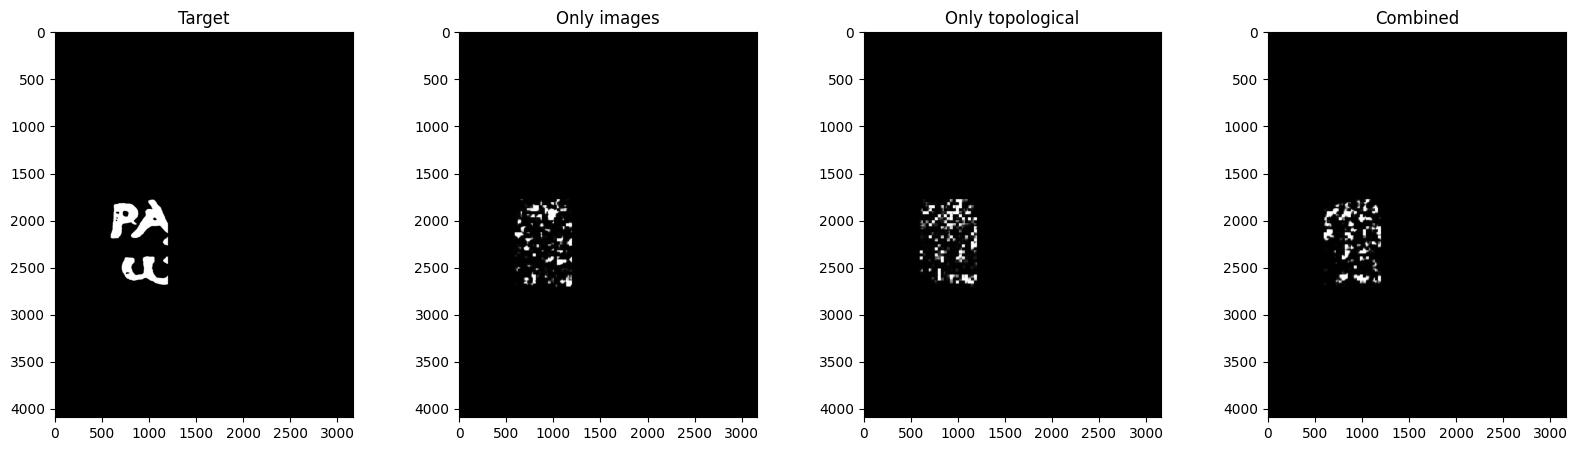

In [11]:
import numpy
import matplotlib.pyplot as plt

def restore(imgs, idxs, ax):
    restored = numpy.zeros((mask.shape[0] // RESIZE_FACTOR, mask.shape[1] // RESIZE_FACTOR))

    for img, (i, j) in zip(imgs, idxs):
        i_from, i_to = i + PADDING, i + WINDOW - PADDING
        j_from, j_to = j + PADDING, j + WINDOW - PADDING
        img_part = img[PADDING:-PADDING, PADDING:-PADDING]
        restored[i_from:i_to, j_from:j_to] = img_part

    ax.imshow(restored, cmap = 'gray')

fig, axes = plt.subplots(1, 4, figsize = (20, 5))

axes[0].set_title("Target")
restore(test_labels, test_idxs, axes[0])

axes[1].set_title("Only images")
restore(numpy.squeeze(numpy.load(f'{PREFIX}/3d/predictions/images.npy')), test_idxs, axes[1])

axes[2].set_title("Only topological")
restore(numpy.squeeze(numpy.load(f'{PREFIX}/3d/predictions/topological.npy')), test_idxs, axes[2])

axes[3].set_title("Combined")
restore(numpy.squeeze(numpy.load(f'{PREFIX}/3d/predictions/combined.npy')), test_idxs, axes[3])